# Mount Google Drive

In [1]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

# Importing necessary libraries

In [2]:
import os
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reading csv dataset

In [4]:
data = pd.read_csv("shopping_trends_updated.csv")
# data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Final_Project/shopping_trends_updated.csv")

# creating dataframe

In [5]:
df = pd.DataFrame(data)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

# Dropping unnecessary features

In [7]:
df.drop('Customer ID', axis=1, inplace=True)

# Encoding non-numerical features

In [8]:
df

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,2-Day Shipping,No,No,32,Venmo,Weekly
3896,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,Store Pickup,No,No,41,Bank Transfer,Bi-Weekly
3897,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Standard,No,No,24,Venmo,Quarterly
3898,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,Express,No,No,24,Venmo,Weekly


In [9]:
# Separating numerical and categorical columns to be used for feature extraction in later code
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).drop('Item Purchased', axis=1).columns.tolist()

In [10]:
non_numeric_cols = df.select_dtypes(include=['object'])

label_encoders = {}

for col in non_numeric_cols:
  encoder = LabelEncoder()
  df[col] = pd.DataFrame(encoder.fit_transform(df[col]))
  label_encoders[col] = encoder


In [13]:
# filename = '/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Final_Project/encoders_dict.pkl'
# pickle.dump(label_encoders, open(filename, 'wb'))

# Feature Extraction with SelectKBest using ANOVA F-value and Chi-squared test

In [14]:
# check correlation to target variable
correlation_matrix = df.corr()['Item Purchased'].sort_values(ascending=False)
print(correlation_matrix)

Item Purchased            1.000000
Category                  0.052951
Color                     0.027241
Location                  0.020390
Shipping Type             0.016244
Frequency of Purchases    0.015249
Season                    0.012755
Subscription Status       0.003028
Gender                    0.001921
Age                      -0.000636
Previous Purchases       -0.001513
Review Rating            -0.004621
Purchase Amount (USD)    -0.005342
Payment Method           -0.006695
Size                     -0.008942
Discount Applied         -0.013983
Promo Code Used          -0.013983
Name: Item Purchased, dtype: float64


In [15]:
X = df.drop('Item Purchased', axis=1)  # Features
y = df['Item Purchased']  # Target variable

# Separate numerical and categorical columns
X_numerical = X[numerical_cols]
X_categorical = X[categorical_cols]

# SelectKBest for numerical columns using f_classif
best_numerical_features = SelectKBest(score_func=f_classif, k='all')
fit_numerical = best_numerical_features.fit(X_numerical, y)

# SelectKBest for categorical columns using chi-squared
best_categorical_features = SelectKBest(score_func=chi2, k=6)
fit_categorical = best_categorical_features.fit(X_categorical, y)

# Get the indices of selected features for numerical and categorical columns
selected_numerical_indices = fit_numerical.get_support(indices=True)
selected_categorical_indices = fit_categorical.get_support(indices=True)

# Get the names of selected numerical features
selected_numerical_features = X_numerical.columns[selected_numerical_indices]

# Get the names of selected categorical features
selected_categorical_features = X_categorical.columns[selected_categorical_indices]

# Combine selected features from both numerical and categorical columns
selected_features = list(selected_numerical_features) + list(selected_categorical_features)
print(selected_features)
print(len(selected_features))

['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 'Category', 'Location', 'Color', 'Season', 'Payment Method', 'Frequency of Purchases']
10


In [16]:
# Concatenate selected features and 'Item Purchased' column
selected_df = pd.concat([df[selected_features], df['Item Purchased']], axis=1)
selected_df

,Age,Purchase Amount (USD),Review Rating,Previous Purchases,Category,Location,Color,Season,Payment Method,Frequency of Purchases,Item Purchased
0,55,53,3.1,14,1,16,7,3,5,3,2
1,19,64,3.1,2,1,18,12,3,1,3,23
2,50,73,3.1,23,1,20,12,1,2,6,11
3,21,90,3.5,49,2,38,12,1,4,6,14
4,45,49,2.7,31,1,36,21,1,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...
3895,40,28,4.2,32,1,45,21,2,5,6,9
3896,52,49,4.5,41,0,14,23,1,0,1,0
3897,46,33,2.9,24,0,29,8,1,5,5,1
3898,44,77,3.8,24,2,22,3,2,5,6,17


In [17]:
df['Item Purchased'].value_counts()
print(len(label_encoders['Item Purchased'].classes_))
label_encoders['Item Purchased'].classes_

25


array(['Backpack', 'Belt', 'Blouse', 'Boots', 'Coat', 'Dress', 'Gloves',
       'Handbag', 'Hat', 'Hoodie', 'Jacket', 'Jeans', 'Jewelry', 'Pants',
       'Sandals', 'Scarf', 'Shirt', 'Shoes', 'Shorts', 'Skirt',
       'Sneakers', 'Socks', 'Sunglasses', 'Sweater', 'T-shirt'],
      dtype=object)

# Exploratory Data Analysis (EDA)

# Scaling

In [18]:
X = selected_df.drop('Item Purchased', axis=1)  # Features
y = selected_df['Item Purchased']  # Target variable

scaler = StandardScaler().fit(X.copy())
X=pd.DataFrame(scaler.transform(X.copy()), columns=X.columns)

In [20]:
# filename = '/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Final_Project/x_scaler.pkl'
# pickle.dump(scaler, open(filename, 'wb'))

# Multi-Layer Perceptron (MLP) using Functional API

In [21]:
def create_model():
  # Define the neural network architecture using the functional API
  input_layer = tf.keras.Input(shape=(X.shape[1],))

  hidden_layer1 = tf.keras.layers.Dense(512, activation='relu')(input_layer)
  dropout1 = tf.keras.layers.Dropout(0.5)(hidden_layer1)

  hidden_layer2 = tf.keras.layers.Dense(512, activation='tanh')(dropout1)
  dropout2 = tf.keras.layers.Dropout(0.5)(hidden_layer2)

  hidden_layer3 = tf.keras.layers.Dense(512, activation='relu')(dropout2)
  dropout3 = tf.keras.layers.Dropout(0.5)(hidden_layer3)

  output_layer = tf.keras.layers.Dense(len(label_encoders['Item Purchased'].classes_), activation='softmax')(dropout3)

  model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

  # Compile the model
  opt=Adam(learning_rate=0.0001)
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

# Cross-Validation using Hold-Out method

In [22]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Graph

In [23]:
model = create_model()
history = model.fit(Xtrain, Ytrain, epochs=200, batch_size=20, validation_data=(Xtest, Ytest), validation_split=0.5)

Epoch 1/200
156/156 [==============================] - 1s 5ms/step - loss: 3.2128 - accuracy: 0.0567 - val_loss: 3.1158 - val_accuracy: 0.0897
Epoch 2/200
156/156 [==============================] - 1s 6ms/step - loss: 3.0852 - accuracy: 0.0808 - val_loss: 2.9331 - val_accuracy: 0.0859
Epoch 3/200
156/156 [==============================] - 1s 6ms/step - loss: 2.8738 - accuracy: 0.1109 - val_loss: 2.7066 - val_accuracy: 0.1128
Epoch 4/200
156/156 [==============================] - 1s 6ms/step - loss: 2.7118 - accuracy: 0.1141 - val_loss: 2.5411 - val_accuracy: 0.1282
Epoch 5/200
156/156 [==============================] - 1s 5ms/step - loss: 2.5887 - accuracy: 0.1375 - val_loss: 2.4182 - val_accuracy: 0.1372
Epoch 6/200
156/156 [==============================] - 1s 5ms/step - loss: 2.5006 - accuracy: 0.1452 - val_loss: 2.3308 - val_accuracy: 0.1205
Epoch 7/200
156/156 [==============================] - 1s 6ms/step - loss: 2.4462 - accuracy: 0.1551 - val_loss: 2.2764 - val_accuracy: 0.1462

Epoch 58/200
156/156 [==============================] - 1s 6ms/step - loss: 2.0005 - accuracy: 0.2224 - val_loss: 2.0464 - val_accuracy: 0.1692
Epoch 59/200
156/156 [==============================] - 1s 6ms/step - loss: 1.9967 - accuracy: 0.2272 - val_loss: 2.0491 - val_accuracy: 0.1551
Epoch 60/200
156/156 [==============================] - 1s 6ms/step - loss: 1.9933 - accuracy: 0.2199 - val_loss: 2.0504 - val_accuracy: 0.1718
Epoch 61/200
156/156 [==============================] - 1s 6ms/step - loss: 2.0009 - accuracy: 0.2163 - val_loss: 2.0497 - val_accuracy: 0.1679
Epoch 62/200
156/156 [==============================] - 1s 7ms/step - loss: 1.9819 - accuracy: 0.2189 - val_loss: 2.0488 - val_accuracy: 0.1615
Epoch 63/200
156/156 [==============================] - 1s 5ms/step - loss: 1.9876 - accuracy: 0.2244 - val_loss: 2.0461 - val_accuracy: 0.1577
Epoch 64/200
156/156 [==============================] - 1s 5ms/step - loss: 1.9831 - accuracy: 0.2260 - val_loss: 2.0487 - val_accuracy:

Epoch 115/200
156/156 [==============================] - 1s 6ms/step - loss: 1.8974 - accuracy: 0.2753 - val_loss: 2.0769 - val_accuracy: 0.1654
Epoch 116/200
156/156 [==============================] - 1s 5ms/step - loss: 1.8975 - accuracy: 0.2708 - val_loss: 2.0773 - val_accuracy: 0.1667
Epoch 117/200
156/156 [==============================] - 1s 5ms/step - loss: 1.8968 - accuracy: 0.2561 - val_loss: 2.0763 - val_accuracy: 0.1718
Epoch 118/200
156/156 [==============================] - 1s 5ms/step - loss: 1.8891 - accuracy: 0.2772 - val_loss: 2.0777 - val_accuracy: 0.1705
Epoch 119/200
156/156 [==============================] - 1s 5ms/step - loss: 1.8848 - accuracy: 0.2683 - val_loss: 2.0792 - val_accuracy: 0.1679
Epoch 120/200
156/156 [==============================] - 1s 5ms/step - loss: 1.8750 - accuracy: 0.2795 - val_loss: 2.0816 - val_accuracy: 0.1808
Epoch 121/200
156/156 [==============================] - 1s 6ms/step - loss: 1.8946 - accuracy: 0.2644 - val_loss: 2.0826 - val_ac

156/156 [==============================] - 1s 5ms/step - loss: 1.8233 - accuracy: 0.3013 - val_loss: 2.1167 - val_accuracy: 0.1679
Epoch 172/200
156/156 [==============================] - 1s 7ms/step - loss: 1.8199 - accuracy: 0.3019 - val_loss: 2.1190 - val_accuracy: 0.1718
Epoch 173/200
156/156 [==============================] - 1s 6ms/step - loss: 1.8267 - accuracy: 0.2974 - val_loss: 2.1172 - val_accuracy: 0.1692
Epoch 174/200
156/156 [==============================] - 1s 5ms/step - loss: 1.8105 - accuracy: 0.3016 - val_loss: 2.1234 - val_accuracy: 0.1718
Epoch 175/200
156/156 [==============================] - 1s 5ms/step - loss: 1.8132 - accuracy: 0.3173 - val_loss: 2.1198 - val_accuracy: 0.1692
Epoch 176/200
156/156 [==============================] - 1s 5ms/step - loss: 1.8155 - accuracy: 0.3032 - val_loss: 2.1221 - val_accuracy: 0.1590
Epoch 177/200
156/156 [==============================] - 1s 6ms/step - loss: 1.8122 - accuracy: 0.3016 - val_loss: 2.1231 - val_accuracy: 0.1667

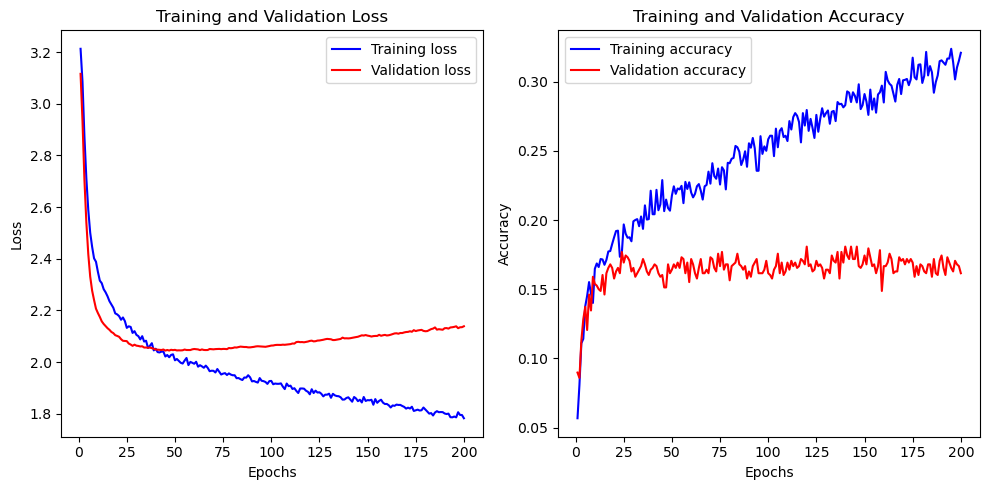

In [24]:
# Plotting training and validation loss across epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy across epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
y_pred = model.predict(Xtest)

25/25 [==============================] - 0s 3ms/step


In [26]:
print(y_pred)

[[5.60201444e-02 9.49790031e-02 9.75879175e-07 ... 1.31241351e-01
  6.40480152e-07 2.44199214e-06]
 [1.30966187e-01 1.12874240e-01 2.21112623e-06 ... 2.08992675e-01
  8.40047221e-07 1.03924185e-06]
 [9.78729054e-02 1.39819175e-01 1.94395966e-06 ... 1.05487838e-01
  2.35205243e-06 3.64225616e-06]
 ...
 [1.32071406e-01 1.23481266e-01 5.60426315e-06 ... 6.24370538e-02
  5.36165817e-06 4.11559404e-06]
 [4.70283694e-18 1.38682496e-17 1.35967775e-05 ... 5.05504267e-17
  4.29213105e-06 6.04651723e-06]
 [1.66024193e-01 8.78681317e-02 1.66263305e-06 ... 1.25792876e-01
  1.98490170e-06 1.90602543e-06]]


In [27]:
predicted_classes = tf.argmax(y_pred, axis=1)
print(predicted_classes)

tf.Tensor(
[ 8 22  7 20 14 18 16  1 11 23 22  8 14  5  6 20 12  4 10  1 18  6  9 14
  0  4 22 14  7 17  3 14 13 23  2  5  3 13 10  2  3 13 20  7  3 18  4 13
  8 21  7 13 20  4 24 23  3  8 13 14 13 20 14 12 12 24 22  5  7 13 24  5
 12  4  2 23  7  6  6  2  0 17  4 14  3  7 24 22  5  7 24 21  2 24  4  2
  2  4 11 15 20 20 20 18  0 15  6 19  9  6  1  9 14 17 22  2  8 13 15 13
 20  6  3 22 21 16 12 14 12 14 11 21  2 19 24 13 13 21 21  7  2  1 10  6
 20  2 19 12  4  4 19 19  4 21  1  7 15  7 14 11 24 23  9 23  1 19 13  7
  2 14 14 21 15 13  3  4 17  2 21 18 22 21 24  7 21 20 17 20 11 12  1 11
 18  7  2 22 21  9 16  0  8 11  7 18 14  3 22 17 22 10  2  2 21 12  7 21
 12  2  7  4  3  7 22 11  7 18  5 19 12 22 16 12 17 17 16 21 13  5  2 21
  9 15  8  3  7 22 16  4  7  7  3  9 10  8 13  9  8 10 18 13 13 19 13 19
 17 14 10  8  2 14  4  5 10  2 13 10  3  4 20 18 20 13 11 10 17 20 10 14
  6 14 11  1  7 11  5 11 13  2 20 13 12 22 17 10 21 20  7  4  0  8  2 21
  7 22 21 21  2 11  5  3  2  0  7 13 14 

In [28]:
print(Ytest)

3236     1
43      15
3454     7
2280    17
280     14
        ..
2781    14
2115    15
402      0
2699     3
1790     6
Name: Item Purchased, Length: 780, dtype: int64


In [29]:
mean_absolute_error(Ytest, predicted_classes)

7.078205128205128

In [30]:
from sklearn.neural_network import MLPClassifier
!pip install scikeras
from scikeras.wrappers import KerasClassifier
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 2.5 MB/s eta 0:00:0000:0100:01


In [31]:
# Create a KerasClassifier
keras_model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=32, verbose=1)

# Fit the model
keras_model.fit(Xtrain, Ytrain)

Epoch 1/150


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


98/98 [==============================] - 1s 7ms/step - loss: 3.2530 - accuracy: 0.0446
Epoch 2/150
98/98 [==============================] - 1s 7ms/step - loss: 3.1528 - accuracy: 0.0673
Epoch 3/150
98/98 [==============================] - 1s 8ms/step - loss: 3.0224 - accuracy: 0.0965
Epoch 4/150
98/98 [==============================] - 1s 7ms/step - loss: 2.8696 - accuracy: 0.1199
Epoch 5/150
98/98 [==============================] - 1s 7ms/step - loss: 2.7365 - accuracy: 0.1170
Epoch 6/150
98/98 [==============================] - 1s 7ms/step - loss: 2.6269 - accuracy: 0.1272
Epoch 7/150
98/98 [==============================] - 1s 6ms/step - loss: 2.5515 - accuracy: 0.1449
Epoch 8/150
98/98 [==============================] - 1s 6ms/step - loss: 2.5051 - accuracy: 0.1391
Epoch 9/150
98/98 [==============================] - 1s 7ms/step - loss: 2.4541 - accuracy: 0.1391
Epoch 10/150
98/98 [==============================] - 1s 7ms/step - loss: 2.4121 - accuracy: 0.1510
Epoch 11/150
98/98 [=

98/98 [==============================] - 1s 6ms/step - loss: 1.9699 - accuracy: 0.2298
Epoch 84/150
98/98 [==============================] - 1s 5ms/step - loss: 1.9676 - accuracy: 0.2340
Epoch 85/150
98/98 [==============================] - 1s 6ms/step - loss: 1.9694 - accuracy: 0.2321
Epoch 86/150
98/98 [==============================] - 1s 7ms/step - loss: 1.9708 - accuracy: 0.2362
Epoch 87/150
98/98 [==============================] - 1s 6ms/step - loss: 1.9530 - accuracy: 0.2449
Epoch 88/150
98/98 [==============================] - 1s 6ms/step - loss: 1.9848 - accuracy: 0.2272
Epoch 89/150
98/98 [==============================] - 1s 7ms/step - loss: 1.9631 - accuracy: 0.2266
Epoch 90/150
98/98 [==============================] - 1s 7ms/step - loss: 1.9707 - accuracy: 0.2285
Epoch 91/150
98/98 [==============================] - 1s 6ms/step - loss: 1.9616 - accuracy: 0.2333
Epoch 92/150
98/98 [==============================] - 1s 6ms/step - loss: 1.9560 - accuracy: 0.2401
Epoch 93/150


KerasClassifier(
	model=None
	build_fn=<function create_model at 0x2922c72e0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=150
	class_weight=None
)

In [32]:
# Predictions on the test set
predictions = keras_model.model_.predict(Xtest)
predicted_classes = tf.argmax(predictions, axis=1)
mean_absolute_error(Ytest, predicted_classes)

25/25 [==============================] - 0s 2ms/step


7.266666666666667

In [33]:
# Define the parameter grid to explore different hyperparameters
param_grid = {
    'batch_size': [10, 32],
    'epochs': [20, 500]
}

grid_DL = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
history = grid_DL.fit(Xtrain, Ytrain, verbose=2)

print("Best: %f using %s" % (grid_DL.best_score_, grid_DL.best_params_))

Epoch 1/20


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 - 1s - loss: 3.2376 - accuracy: 0.0513 - 1s/epoch - 5ms/step
Epoch 2/20
250/250 - 1s - loss: 3.0640 - accuracy: 0.0974 - 1s/epoch - 4ms/step
Epoch 3/20
250/250 - 1s - loss: 2.8534 - accuracy: 0.1054 - 1s/epoch - 5ms/step
Epoch 4/20
250/250 - 1s - loss: 2.6744 - accuracy: 0.1302 - 1s/epoch - 5ms/step
Epoch 5/20
250/250 - 1s - loss: 2.5452 - accuracy: 0.1418 - 1s/epoch - 5ms/step
Epoch 6/20
250/250 - 1s - loss: 2.4456 - accuracy: 0.1498 - 1s/epoch - 5ms/step
Epoch 7/20
250/250 - 1s - loss: 2.4071 - accuracy: 0.1462 - 1s/epoch - 5ms/step
Epoch 8/20
250/250 - 1s - loss: 2.3610 - accuracy: 0.1611 - 1s/epoch - 4ms/step
Epoch 9/20
250/250 - 1s - loss: 2.3549 - accuracy: 0.1402 - 1s/epoch - 4ms/step
Epoch 10/20
250/250 - 1s - loss: 2.3167 - accuracy: 0.1599 - 958ms/epoch - 4ms/step
Epoch 11/20
250/250 - 1s - loss: 2.3179 - accuracy: 0.1522 - 915ms/epoch - 4ms/step
Epoch 12/20
250/250 - 1s - loss: 2.2850 - accuracy: 0.1635 - 1s/epoch - 4ms/step
Epoch 13/20
250/250 - 1s - loss: 2.2630 - 

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 - 1s - loss: 3.2335 - accuracy: 0.0557 - 1s/epoch - 5ms/step
Epoch 2/20
250/250 - 1s - loss: 3.0697 - accuracy: 0.0966 - 1s/epoch - 5ms/step
Epoch 3/20
250/250 - 1s - loss: 2.8671 - accuracy: 0.1086 - 1s/epoch - 5ms/step
Epoch 4/20
250/250 - 1s - loss: 2.6656 - accuracy: 0.1262 - 1s/epoch - 5ms/step
Epoch 5/20
250/250 - 1s - loss: 2.5525 - accuracy: 0.1366 - 1s/epoch - 4ms/step
Epoch 6/20
250/250 - 1s - loss: 2.4665 - accuracy: 0.1362 - 1s/epoch - 4ms/step
Epoch 7/20
250/250 - 1s - loss: 2.4074 - accuracy: 0.1583 - 978ms/epoch - 4ms/step
Epoch 8/20
250/250 - 1s - loss: 2.3633 - accuracy: 0.1663 - 1s/epoch - 4ms/step
Epoch 9/20
250/250 - 1s - loss: 2.3310 - accuracy: 0.1591 - 951ms/epoch - 4ms/step
Epoch 10/20
250/250 - 1s - loss: 2.3029 - accuracy: 0.1779 - 1s/epoch - 4ms/step
Epoch 11/20
250/250 - 1s - loss: 2.2893 - accuracy: 0.1711 - 1s/epoch - 4ms/step
Epoch 12/20
250/250 - 1s - loss: 2.2505 - accuracy: 0.1723 - 1s/epoch - 4ms/step
Epoch 13/20
250/250 - 1s - loss: 2.2490 - 

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 - 1s - loss: 3.2221 - accuracy: 0.0585 - 1s/epoch - 4ms/step
Epoch 2/20
250/250 - 1s - loss: 3.0556 - accuracy: 0.0990 - 991ms/epoch - 4ms/step
Epoch 3/20
250/250 - 1s - loss: 2.8278 - accuracy: 0.1134 - 928ms/epoch - 4ms/step
Epoch 4/20
250/250 - 1s - loss: 2.6914 - accuracy: 0.1190 - 1s/epoch - 5ms/step
Epoch 5/20
250/250 - 1s - loss: 2.5584 - accuracy: 0.1414 - 1s/epoch - 4ms/step
Epoch 6/20
250/250 - 1s - loss: 2.4561 - accuracy: 0.1558 - 1s/epoch - 5ms/step
Epoch 7/20
250/250 - 1s - loss: 2.4173 - accuracy: 0.1550 - 1s/epoch - 5ms/step
Epoch 8/20
250/250 - 1s - loss: 2.3626 - accuracy: 0.1675 - 1s/epoch - 4ms/step
Epoch 9/20
250/250 - 1s - loss: 2.3515 - accuracy: 0.1558 - 1s/epoch - 4ms/step
Epoch 10/20
250/250 - 1s - loss: 2.3100 - accuracy: 0.1727 - 979ms/epoch - 4ms/step
Epoch 11/20
250/250 - 1s - loss: 2.2954 - accuracy: 0.1791 - 1s/epoch - 4ms/step
Epoch 12/20
250/250 - 1s - loss: 2.2768 - accuracy: 0.1667 - 1s/epoch - 4ms/step
Epoch 13/20
250/250 - 1s - loss: 2.2561

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 - 1s - loss: 3.2111 - accuracy: 0.0637 - 1s/epoch - 5ms/step
Epoch 2/20
250/250 - 1s - loss: 3.0425 - accuracy: 0.0982 - 1s/epoch - 4ms/step
Epoch 3/20
250/250 - 1s - loss: 2.8170 - accuracy: 0.1214 - 1s/epoch - 4ms/step
Epoch 4/20
250/250 - 1s - loss: 2.6473 - accuracy: 0.1290 - 1s/epoch - 5ms/step
Epoch 5/20
250/250 - 1s - loss: 2.5292 - accuracy: 0.1406 - 1s/epoch - 6ms/step
Epoch 6/20
250/250 - 1s - loss: 2.4600 - accuracy: 0.1446 - 1s/epoch - 4ms/step
Epoch 7/20
250/250 - 1s - loss: 2.4005 - accuracy: 0.1542 - 1s/epoch - 4ms/step
Epoch 8/20
250/250 - 1s - loss: 2.3799 - accuracy: 0.1434 - 1s/epoch - 5ms/step
Epoch 9/20
250/250 - 1s - loss: 2.3236 - accuracy: 0.1567 - 969ms/epoch - 4ms/step
Epoch 10/20
250/250 - 1s - loss: 2.3199 - accuracy: 0.1667 - 954ms/epoch - 4ms/step
Epoch 11/20
250/250 - 1s - loss: 2.2861 - accuracy: 0.1727 - 891ms/epoch - 4ms/step
Epoch 12/20
250/250 - 1s - loss: 2.2818 - accuracy: 0.1743 - 1s/epoch - 4ms/step
Epoch 13/20
250/250 - 1s - loss: 2.2741

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 - 1s - loss: 3.2450 - accuracy: 0.0477 - 1s/epoch - 5ms/step
Epoch 2/20
250/250 - 1s - loss: 3.0832 - accuracy: 0.0966 - 1s/epoch - 5ms/step
Epoch 3/20
250/250 - 1s - loss: 2.8720 - accuracy: 0.1114 - 1s/epoch - 5ms/step
Epoch 4/20
250/250 - 1s - loss: 2.6875 - accuracy: 0.1310 - 1s/epoch - 4ms/step
Epoch 5/20
250/250 - 1s - loss: 2.5508 - accuracy: 0.1474 - 1s/epoch - 5ms/step
Epoch 6/20
250/250 - 1s - loss: 2.4780 - accuracy: 0.1446 - 1s/epoch - 4ms/step
Epoch 7/20
250/250 - 1s - loss: 2.4387 - accuracy: 0.1510 - 953ms/epoch - 4ms/step
Epoch 8/20
250/250 - 1s - loss: 2.3779 - accuracy: 0.1571 - 1s/epoch - 5ms/step
Epoch 9/20
250/250 - 1s - loss: 2.3535 - accuracy: 0.1751 - 1s/epoch - 4ms/step
Epoch 10/20
250/250 - 1s - loss: 2.3419 - accuracy: 0.1595 - 1s/epoch - 4ms/step
Epoch 11/20
250/250 - 1s - loss: 2.2824 - accuracy: 0.1779 - 1s/epoch - 4ms/step
Epoch 12/20
250/250 - 1s - loss: 2.2711 - accuracy: 0.1771 - 939ms/epoch - 4ms/step
Epoch 13/20
250/250 - 1s - loss: 2.2596 - 

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 - 1s - loss: 3.2202 - accuracy: 0.0533 - 995ms/epoch - 4ms/step
Epoch 2/500
250/250 - 1s - loss: 3.0711 - accuracy: 0.0805 - 743ms/epoch - 3ms/step
Epoch 3/500
250/250 - 1s - loss: 2.8471 - accuracy: 0.1046 - 897ms/epoch - 4ms/step
Epoch 4/500
250/250 - 1s - loss: 2.6760 - accuracy: 0.1266 - 1s/epoch - 4ms/step
Epoch 5/500
250/250 - 1s - loss: 2.5583 - accuracy: 0.1374 - 956ms/epoch - 4ms/step
Epoch 6/500
250/250 - 1s - loss: 2.4793 - accuracy: 0.1538 - 777ms/epoch - 3ms/step
Epoch 7/500
250/250 - 1s - loss: 2.4033 - accuracy: 0.1623 - 1s/epoch - 4ms/step
Epoch 8/500
250/250 - 1s - loss: 2.3805 - accuracy: 0.1554 - 851ms/epoch - 3ms/step
Epoch 9/500
250/250 - 1s - loss: 2.3648 - accuracy: 0.1486 - 901ms/epoch - 4ms/step
Epoch 10/500
250/250 - 1s - loss: 2.3286 - accuracy: 0.1514 - 986ms/epoch - 4ms/step
Epoch 11/500
250/250 - 1s - loss: 2.3100 - accuracy: 0.1478 - 951ms/epoch - 4ms/step
Epoch 12/500
250/250 - 1s - loss: 2.2902 - accuracy: 0.1607 - 895ms/epoch - 4ms/step
Epoch 1

Epoch 101/500
250/250 - 1s - loss: 1.8629 - accuracy: 0.2808 - 1s/epoch - 5ms/step
Epoch 102/500
250/250 - 1s - loss: 1.8511 - accuracy: 0.2945 - 1s/epoch - 5ms/step
Epoch 103/500
250/250 - 1s - loss: 1.8557 - accuracy: 0.2933 - 1s/epoch - 5ms/step
Epoch 104/500
250/250 - 1s - loss: 1.8492 - accuracy: 0.2945 - 1s/epoch - 4ms/step
Epoch 105/500
250/250 - 1s - loss: 1.8487 - accuracy: 0.3017 - 993ms/epoch - 4ms/step
Epoch 106/500
250/250 - 1s - loss: 1.8554 - accuracy: 0.2812 - 1s/epoch - 4ms/step
Epoch 107/500
250/250 - 1s - loss: 1.8343 - accuracy: 0.3017 - 1s/epoch - 4ms/step
Epoch 108/500
250/250 - 1s - loss: 1.8377 - accuracy: 0.3017 - 1s/epoch - 4ms/step
Epoch 109/500
250/250 - 1s - loss: 1.8280 - accuracy: 0.3013 - 1s/epoch - 4ms/step
Epoch 110/500
250/250 - 1s - loss: 1.8381 - accuracy: 0.3101 - 1s/epoch - 5ms/step
Epoch 111/500
250/250 - 1s - loss: 1.8406 - accuracy: 0.3049 - 1s/epoch - 5ms/step
Epoch 112/500
250/250 - 1s - loss: 1.8325 - accuracy: 0.3013 - 1s/epoch - 4ms/step
E

250/250 - 1s - loss: 1.6752 - accuracy: 0.3698 - 990ms/epoch - 4ms/step
Epoch 200/500
250/250 - 1s - loss: 1.6622 - accuracy: 0.3754 - 914ms/epoch - 4ms/step
Epoch 201/500
250/250 - 1s - loss: 1.6693 - accuracy: 0.3646 - 1s/epoch - 5ms/step
Epoch 202/500
250/250 - 1s - loss: 1.6615 - accuracy: 0.3738 - 1s/epoch - 4ms/step
Epoch 203/500
250/250 - 1s - loss: 1.6550 - accuracy: 0.3834 - 1s/epoch - 5ms/step
Epoch 204/500
250/250 - 1s - loss: 1.6626 - accuracy: 0.3782 - 1s/epoch - 4ms/step
Epoch 205/500
250/250 - 1s - loss: 1.6586 - accuracy: 0.3878 - 1s/epoch - 4ms/step
Epoch 206/500
250/250 - 1s - loss: 1.6804 - accuracy: 0.3690 - 1s/epoch - 5ms/step
Epoch 207/500
250/250 - 1s - loss: 1.6490 - accuracy: 0.3698 - 1s/epoch - 5ms/step
Epoch 208/500
250/250 - 1s - loss: 1.6802 - accuracy: 0.3766 - 1s/epoch - 4ms/step
Epoch 209/500
250/250 - 1s - loss: 1.6517 - accuracy: 0.3818 - 976ms/epoch - 4ms/step
Epoch 210/500
250/250 - 1s - loss: 1.6400 - accuracy: 0.3910 - 973ms/epoch - 4ms/step
Epoch 

Epoch 298/500
250/250 - 1s - loss: 1.5099 - accuracy: 0.4475 - 1s/epoch - 5ms/step
Epoch 299/500
250/250 - 1s - loss: 1.5262 - accuracy: 0.4371 - 1s/epoch - 4ms/step
Epoch 300/500
250/250 - 1s - loss: 1.5121 - accuracy: 0.4463 - 1s/epoch - 5ms/step
Epoch 301/500
250/250 - 1s - loss: 1.4944 - accuracy: 0.4387 - 1s/epoch - 4ms/step
Epoch 302/500
250/250 - 1s - loss: 1.5038 - accuracy: 0.4503 - 916ms/epoch - 4ms/step
Epoch 303/500
250/250 - 1s - loss: 1.5016 - accuracy: 0.4479 - 987ms/epoch - 4ms/step
Epoch 304/500
250/250 - 1s - loss: 1.5333 - accuracy: 0.4267 - 1s/epoch - 5ms/step
Epoch 305/500
250/250 - 1s - loss: 1.4873 - accuracy: 0.4475 - 1s/epoch - 4ms/step
Epoch 306/500
250/250 - 1s - loss: 1.5196 - accuracy: 0.4291 - 1s/epoch - 4ms/step
Epoch 307/500
250/250 - 1s - loss: 1.5004 - accuracy: 0.4463 - 1s/epoch - 5ms/step
Epoch 308/500
250/250 - 1s - loss: 1.5168 - accuracy: 0.4431 - 1s/epoch - 4ms/step
Epoch 309/500
250/250 - 1s - loss: 1.4945 - accuracy: 0.4343 - 1s/epoch - 5ms/ste

250/250 - 2s - loss: 1.4129 - accuracy: 0.4724 - 2s/epoch - 6ms/step
Epoch 397/500
250/250 - 2s - loss: 1.4007 - accuracy: 0.4864 - 2s/epoch - 6ms/step
Epoch 398/500
250/250 - 1s - loss: 1.3947 - accuracy: 0.4880 - 1s/epoch - 6ms/step
Epoch 399/500
250/250 - 1s - loss: 1.4199 - accuracy: 0.4896 - 1s/epoch - 5ms/step
Epoch 400/500
250/250 - 1s - loss: 1.3934 - accuracy: 0.4804 - 1s/epoch - 5ms/step
Epoch 401/500
250/250 - 1s - loss: 1.3881 - accuracy: 0.4872 - 1s/epoch - 5ms/step
Epoch 402/500
250/250 - 1s - loss: 1.4096 - accuracy: 0.4804 - 1s/epoch - 5ms/step
Epoch 403/500
250/250 - 1s - loss: 1.3980 - accuracy: 0.4848 - 974ms/epoch - 4ms/step
Epoch 404/500
250/250 - 1s - loss: 1.3881 - accuracy: 0.4844 - 1s/epoch - 5ms/step
Epoch 405/500
250/250 - 1s - loss: 1.3980 - accuracy: 0.4772 - 1s/epoch - 5ms/step
Epoch 406/500
250/250 - 1s - loss: 1.4037 - accuracy: 0.4800 - 1s/epoch - 5ms/step
Epoch 407/500
250/250 - 1s - loss: 1.4109 - accuracy: 0.4936 - 1s/epoch - 5ms/step
Epoch 408/500
2

Epoch 495/500
250/250 - 1s - loss: 1.3230 - accuracy: 0.5080 - 1s/epoch - 5ms/step
Epoch 496/500
250/250 - 1s - loss: 1.2777 - accuracy: 0.5365 - 1s/epoch - 5ms/step
Epoch 497/500
250/250 - 1s - loss: 1.2896 - accuracy: 0.5212 - 1s/epoch - 5ms/step
Epoch 498/500
250/250 - 1s - loss: 1.2897 - accuracy: 0.5329 - 980ms/epoch - 4ms/step
Epoch 499/500
250/250 - 1s - loss: 1.2837 - accuracy: 0.5377 - 942ms/epoch - 4ms/step
Epoch 500/500
250/250 - 1s - loss: 1.2966 - accuracy: 0.5317 - 1s/epoch - 5ms/step
63/63 [==============================] - 0s 1ms/step
Epoch 1/500


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 - 1s - loss: 3.2303 - accuracy: 0.0677 - 1s/epoch - 5ms/step
Epoch 2/500
250/250 - 1s - loss: 3.0724 - accuracy: 0.0901 - 1s/epoch - 4ms/step
Epoch 3/500
250/250 - 1s - loss: 2.8569 - accuracy: 0.1146 - 1s/epoch - 4ms/step
Epoch 4/500
250/250 - 1s - loss: 2.6819 - accuracy: 0.1230 - 898ms/epoch - 4ms/step
Epoch 5/500
250/250 - 1s - loss: 2.5427 - accuracy: 0.1346 - 1s/epoch - 5ms/step
Epoch 6/500
250/250 - 1s - loss: 2.4755 - accuracy: 0.1442 - 1s/epoch - 4ms/step
Epoch 7/500
250/250 - 1s - loss: 2.3992 - accuracy: 0.1534 - 1s/epoch - 4ms/step
Epoch 8/500
250/250 - 1s - loss: 2.3596 - accuracy: 0.1627 - 983ms/epoch - 4ms/step
Epoch 9/500
250/250 - 1s - loss: 2.3422 - accuracy: 0.1615 - 1s/epoch - 5ms/step
Epoch 10/500
250/250 - 1s - loss: 2.3220 - accuracy: 0.1583 - 1s/epoch - 4ms/step
Epoch 11/500
250/250 - 1s - loss: 2.2988 - accuracy: 0.1723 - 954ms/epoch - 4ms/step
Epoch 12/500
250/250 - 1s - loss: 2.2761 - accuracy: 0.1751 - 1s/epoch - 5ms/step
Epoch 13/500
250/250 - 1s - 

Epoch 101/500
250/250 - 1s - loss: 1.8575 - accuracy: 0.2909 - 1s/epoch - 4ms/step
Epoch 102/500
250/250 - 1s - loss: 1.8728 - accuracy: 0.2740 - 1s/epoch - 4ms/step
Epoch 103/500
250/250 - 1s - loss: 1.8290 - accuracy: 0.2981 - 936ms/epoch - 4ms/step
Epoch 104/500
250/250 - 1s - loss: 1.8466 - accuracy: 0.2897 - 1s/epoch - 4ms/step
Epoch 105/500
250/250 - 1s - loss: 1.8519 - accuracy: 0.2909 - 994ms/epoch - 4ms/step
Epoch 106/500
250/250 - 1s - loss: 1.8476 - accuracy: 0.2901 - 1s/epoch - 4ms/step
Epoch 107/500
250/250 - 1s - loss: 1.8439 - accuracy: 0.2800 - 1s/epoch - 6ms/step
Epoch 108/500
250/250 - 1s - loss: 1.8430 - accuracy: 0.2993 - 1s/epoch - 5ms/step
Epoch 109/500
250/250 - 1s - loss: 1.8383 - accuracy: 0.3037 - 999ms/epoch - 4ms/step
Epoch 110/500
250/250 - 1s - loss: 1.8430 - accuracy: 0.3005 - 1s/epoch - 4ms/step
Epoch 111/500
250/250 - 1s - loss: 1.8491 - accuracy: 0.2849 - 1s/epoch - 5ms/step
Epoch 112/500
250/250 - 1s - loss: 1.8388 - accuracy: 0.3005 - 1s/epoch - 5ms/

Epoch 200/500
250/250 - 1s - loss: 1.6856 - accuracy: 0.3586 - 1s/epoch - 5ms/step
Epoch 201/500
250/250 - 1s - loss: 1.6733 - accuracy: 0.3546 - 1s/epoch - 5ms/step
Epoch 202/500
250/250 - 1s - loss: 1.6807 - accuracy: 0.3746 - 1s/epoch - 5ms/step
Epoch 203/500
250/250 - 1s - loss: 1.6852 - accuracy: 0.3562 - 1s/epoch - 4ms/step
Epoch 204/500
250/250 - 1s - loss: 1.6684 - accuracy: 0.3602 - 1s/epoch - 5ms/step
Epoch 205/500
250/250 - 1s - loss: 1.6689 - accuracy: 0.3682 - 1s/epoch - 5ms/step
Epoch 206/500
250/250 - 1s - loss: 1.6826 - accuracy: 0.3674 - 1s/epoch - 4ms/step
Epoch 207/500
250/250 - 1s - loss: 1.6756 - accuracy: 0.3598 - 1s/epoch - 4ms/step
Epoch 208/500
250/250 - 1s - loss: 1.6668 - accuracy: 0.3710 - 1s/epoch - 4ms/step
Epoch 209/500
250/250 - 1s - loss: 1.6962 - accuracy: 0.3738 - 1s/epoch - 5ms/step
Epoch 210/500
250/250 - 1s - loss: 1.6644 - accuracy: 0.3810 - 1s/epoch - 5ms/step
Epoch 211/500
250/250 - 1s - loss: 1.6710 - accuracy: 0.3646 - 1s/epoch - 4ms/step
Epoc

Epoch 299/500
250/250 - 1s - loss: 1.5212 - accuracy: 0.4279 - 991ms/epoch - 4ms/step
Epoch 300/500
250/250 - 1s - loss: 1.5231 - accuracy: 0.4295 - 1s/epoch - 5ms/step
Epoch 301/500
250/250 - 1s - loss: 1.5238 - accuracy: 0.4235 - 955ms/epoch - 4ms/step
Epoch 302/500
250/250 - 1s - loss: 1.4973 - accuracy: 0.4379 - 1s/epoch - 4ms/step
Epoch 303/500
250/250 - 1s - loss: 1.5246 - accuracy: 0.4347 - 997ms/epoch - 4ms/step
Epoch 304/500
250/250 - 1s - loss: 1.5215 - accuracy: 0.4215 - 1s/epoch - 5ms/step
Epoch 305/500
250/250 - 1s - loss: 1.5220 - accuracy: 0.4315 - 1s/epoch - 5ms/step
Epoch 306/500
250/250 - 1s - loss: 1.5240 - accuracy: 0.4335 - 1s/epoch - 4ms/step
Epoch 307/500
250/250 - 1s - loss: 1.5414 - accuracy: 0.4259 - 1s/epoch - 4ms/step
Epoch 308/500
250/250 - 1s - loss: 1.5250 - accuracy: 0.4307 - 1s/epoch - 4ms/step
Epoch 309/500
250/250 - 1s - loss: 1.4994 - accuracy: 0.4311 - 1s/epoch - 4ms/step
Epoch 310/500
250/250 - 1s - loss: 1.5232 - accuracy: 0.4255 - 1s/epoch - 4ms/

Epoch 398/500
250/250 - 1s - loss: 1.4190 - accuracy: 0.4776 - 900ms/epoch - 4ms/step
Epoch 399/500
250/250 - 1s - loss: 1.4036 - accuracy: 0.4844 - 1s/epoch - 4ms/step
Epoch 400/500
250/250 - 1s - loss: 1.4111 - accuracy: 0.4724 - 1s/epoch - 5ms/step
Epoch 401/500
250/250 - 1s - loss: 1.3937 - accuracy: 0.4900 - 1s/epoch - 5ms/step
Epoch 402/500
250/250 - 1s - loss: 1.3907 - accuracy: 0.4864 - 1s/epoch - 4ms/step
Epoch 403/500
250/250 - 1s - loss: 1.3989 - accuracy: 0.4792 - 982ms/epoch - 4ms/step
Epoch 404/500
250/250 - 1s - loss: 1.3863 - accuracy: 0.4864 - 955ms/epoch - 4ms/step
Epoch 405/500
250/250 - 1s - loss: 1.4186 - accuracy: 0.4828 - 1s/epoch - 5ms/step
Epoch 406/500
250/250 - 1s - loss: 1.4087 - accuracy: 0.4736 - 1s/epoch - 4ms/step
Epoch 407/500
250/250 - 1s - loss: 1.4035 - accuracy: 0.4772 - 1s/epoch - 4ms/step
Epoch 408/500
250/250 - 1s - loss: 1.4167 - accuracy: 0.4764 - 969ms/epoch - 4ms/step
Epoch 409/500
250/250 - 1s - loss: 1.4203 - accuracy: 0.4840 - 909ms/epoch 

Epoch 496/500
250/250 - 1s - loss: 1.2877 - accuracy: 0.5260 - 1s/epoch - 4ms/step
Epoch 497/500
250/250 - 1s - loss: 1.3413 - accuracy: 0.4964 - 1s/epoch - 4ms/step
Epoch 498/500
250/250 - 1s - loss: 1.3126 - accuracy: 0.5252 - 1s/epoch - 5ms/step
Epoch 499/500
250/250 - 1s - loss: 1.3225 - accuracy: 0.5248 - 1s/epoch - 4ms/step
Epoch 500/500
250/250 - 1s - loss: 1.2934 - accuracy: 0.5365 - 1s/epoch - 4ms/step
63/63 [==============================] - 0s 1ms/step
Epoch 1/500


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 - 1s - loss: 3.2042 - accuracy: 0.0525 - 1s/epoch - 5ms/step
Epoch 2/500
250/250 - 1s - loss: 3.0310 - accuracy: 0.0958 - 1s/epoch - 5ms/step
Epoch 3/500
250/250 - 1s - loss: 2.8286 - accuracy: 0.1106 - 1s/epoch - 4ms/step
Epoch 4/500
250/250 - 1s - loss: 2.6350 - accuracy: 0.1270 - 917ms/epoch - 4ms/step
Epoch 5/500
250/250 - 1s - loss: 2.5345 - accuracy: 0.1318 - 1s/epoch - 4ms/step
Epoch 6/500
250/250 - 1s - loss: 2.4517 - accuracy: 0.1506 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 2.4121 - accuracy: 0.1418 - 1s/epoch - 5ms/step
Epoch 8/500
250/250 - 1s - loss: 2.3819 - accuracy: 0.1498 - 1s/epoch - 5ms/step
Epoch 9/500
250/250 - 1s - loss: 2.3367 - accuracy: 0.1615 - 1s/epoch - 4ms/step
Epoch 10/500
250/250 - 1s - loss: 2.3412 - accuracy: 0.1607 - 954ms/epoch - 4ms/step
Epoch 11/500
250/250 - 1s - loss: 2.3029 - accuracy: 0.1611 - 1s/epoch - 4ms/step
Epoch 12/500
250/250 - 1s - loss: 2.2733 - accuracy: 0.1603 - 927ms/epoch - 4ms/step
Epoch 13/500
250/250 - 1s - 

Epoch 101/500
250/250 - 1s - loss: 1.8652 - accuracy: 0.2825 - 1s/epoch - 4ms/step
Epoch 102/500
250/250 - 1s - loss: 1.8391 - accuracy: 0.3029 - 918ms/epoch - 4ms/step
Epoch 103/500
250/250 - 1s - loss: 1.8545 - accuracy: 0.2905 - 1s/epoch - 5ms/step
Epoch 104/500
250/250 - 1s - loss: 1.8523 - accuracy: 0.2833 - 1s/epoch - 4ms/step
Epoch 105/500
250/250 - 1s - loss: 1.8576 - accuracy: 0.2889 - 1s/epoch - 4ms/step
Epoch 106/500
250/250 - 1s - loss: 1.8531 - accuracy: 0.2881 - 940ms/epoch - 4ms/step
Epoch 107/500
250/250 - 1s - loss: 1.8449 - accuracy: 0.3001 - 982ms/epoch - 4ms/step
Epoch 108/500
250/250 - 1s - loss: 1.8502 - accuracy: 0.2937 - 1s/epoch - 4ms/step
Epoch 109/500
250/250 - 1s - loss: 1.8614 - accuracy: 0.2764 - 1s/epoch - 5ms/step
Epoch 110/500
250/250 - 1s - loss: 1.8493 - accuracy: 0.2825 - 909ms/epoch - 4ms/step
Epoch 111/500
250/250 - 1s - loss: 1.8331 - accuracy: 0.2973 - 878ms/epoch - 4ms/step
Epoch 112/500
250/250 - 1s - loss: 1.8623 - accuracy: 0.2861 - 1s/epoch 

Epoch 199/500
250/250 - 1s - loss: 1.6814 - accuracy: 0.3630 - 1s/epoch - 4ms/step
Epoch 200/500
250/250 - 1s - loss: 1.6831 - accuracy: 0.3610 - 1s/epoch - 4ms/step
Epoch 201/500
250/250 - 1s - loss: 1.6566 - accuracy: 0.3814 - 1s/epoch - 4ms/step
Epoch 202/500
250/250 - 1s - loss: 1.6684 - accuracy: 0.3762 - 1s/epoch - 4ms/step
Epoch 203/500
250/250 - 1s - loss: 1.6841 - accuracy: 0.3566 - 1s/epoch - 4ms/step
Epoch 204/500
250/250 - 1s - loss: 1.6668 - accuracy: 0.3734 - 1s/epoch - 5ms/step
Epoch 205/500
250/250 - 1s - loss: 1.6853 - accuracy: 0.3570 - 1s/epoch - 4ms/step
Epoch 206/500
250/250 - 1s - loss: 1.6803 - accuracy: 0.3638 - 900ms/epoch - 4ms/step
Epoch 207/500
250/250 - 1s - loss: 1.6632 - accuracy: 0.3662 - 1s/epoch - 4ms/step
Epoch 208/500
250/250 - 1s - loss: 1.6728 - accuracy: 0.3702 - 1s/epoch - 4ms/step
Epoch 209/500
250/250 - 1s - loss: 1.6683 - accuracy: 0.3690 - 853ms/epoch - 3ms/step
Epoch 210/500
250/250 - 1s - loss: 1.6661 - accuracy: 0.3782 - 997ms/epoch - 4ms/

Epoch 297/500
250/250 - 1s - loss: 1.5438 - accuracy: 0.4231 - 917ms/epoch - 4ms/step
Epoch 298/500
250/250 - 1s - loss: 1.5351 - accuracy: 0.4207 - 969ms/epoch - 4ms/step
Epoch 299/500
250/250 - 1s - loss: 1.5399 - accuracy: 0.4299 - 866ms/epoch - 3ms/step
Epoch 300/500
250/250 - 1s - loss: 1.5526 - accuracy: 0.4187 - 1s/epoch - 4ms/step
Epoch 301/500
250/250 - 1s - loss: 1.5316 - accuracy: 0.4207 - 1s/epoch - 5ms/step
Epoch 302/500
250/250 - 1s - loss: 1.5188 - accuracy: 0.4339 - 1s/epoch - 5ms/step
Epoch 303/500
250/250 - 1s - loss: 1.5100 - accuracy: 0.4287 - 1s/epoch - 4ms/step
Epoch 304/500
250/250 - 1s - loss: 1.5481 - accuracy: 0.4283 - 1s/epoch - 4ms/step
Epoch 305/500
250/250 - 1s - loss: 1.5208 - accuracy: 0.4335 - 1s/epoch - 5ms/step
Epoch 306/500
250/250 - 1s - loss: 1.5263 - accuracy: 0.4247 - 1s/epoch - 4ms/step
Epoch 307/500
250/250 - 1s - loss: 1.5162 - accuracy: 0.4367 - 1s/epoch - 4ms/step
Epoch 308/500
250/250 - 1s - loss: 1.5277 - accuracy: 0.4315 - 1s/epoch - 5ms/

Epoch 395/500
250/250 - 1s - loss: 1.3933 - accuracy: 0.4876 - 1s/epoch - 5ms/step
Epoch 396/500
250/250 - 1s - loss: 1.3868 - accuracy: 0.4760 - 1s/epoch - 4ms/step
Epoch 397/500
250/250 - 1s - loss: 1.4162 - accuracy: 0.4716 - 1s/epoch - 5ms/step
Epoch 398/500
250/250 - 1s - loss: 1.4088 - accuracy: 0.4784 - 1s/epoch - 6ms/step
Epoch 399/500
250/250 - 1s - loss: 1.3861 - accuracy: 0.4824 - 1s/epoch - 5ms/step
Epoch 400/500
250/250 - 1s - loss: 1.4134 - accuracy: 0.4744 - 1s/epoch - 5ms/step
Epoch 401/500
250/250 - 1s - loss: 1.4162 - accuracy: 0.4712 - 1s/epoch - 4ms/step
Epoch 402/500
250/250 - 1s - loss: 1.4107 - accuracy: 0.4724 - 1s/epoch - 5ms/step
Epoch 403/500
250/250 - 1s - loss: 1.4172 - accuracy: 0.4820 - 1s/epoch - 4ms/step
Epoch 404/500
250/250 - 1s - loss: 1.3877 - accuracy: 0.4868 - 1s/epoch - 5ms/step
Epoch 405/500
250/250 - 1s - loss: 1.4023 - accuracy: 0.4852 - 1s/epoch - 4ms/step
Epoch 406/500
250/250 - 1s - loss: 1.4173 - accuracy: 0.4904 - 1s/epoch - 5ms/step
Epoc

Epoch 494/500
250/250 - 1s - loss: 1.3171 - accuracy: 0.5148 - 1s/epoch - 5ms/step
Epoch 495/500
250/250 - 1s - loss: 1.3245 - accuracy: 0.5196 - 1s/epoch - 4ms/step
Epoch 496/500
250/250 - 1s - loss: 1.2957 - accuracy: 0.5280 - 1s/epoch - 5ms/step
Epoch 497/500
250/250 - 1s - loss: 1.2943 - accuracy: 0.5268 - 1s/epoch - 5ms/step
Epoch 498/500
250/250 - 1s - loss: 1.3252 - accuracy: 0.5000 - 1s/epoch - 5ms/step
Epoch 499/500
250/250 - 1s - loss: 1.3070 - accuracy: 0.5136 - 1s/epoch - 5ms/step
Epoch 500/500
250/250 - 1s - loss: 1.3110 - accuracy: 0.5264 - 1s/epoch - 5ms/step
63/63 [==============================] - 0s 1ms/step
Epoch 1/500


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 - 1s - loss: 3.2145 - accuracy: 0.0625 - 1s/epoch - 5ms/step
Epoch 2/500
250/250 - 1s - loss: 3.0497 - accuracy: 0.1014 - 1s/epoch - 4ms/step
Epoch 3/500
250/250 - 1s - loss: 2.8297 - accuracy: 0.1190 - 1s/epoch - 4ms/step
Epoch 4/500
250/250 - 1s - loss: 2.6624 - accuracy: 0.1358 - 1s/epoch - 4ms/step
Epoch 5/500
250/250 - 1s - loss: 2.5506 - accuracy: 0.1402 - 1s/epoch - 4ms/step
Epoch 6/500
250/250 - 1s - loss: 2.4662 - accuracy: 0.1422 - 1s/epoch - 5ms/step
Epoch 7/500
250/250 - 1s - loss: 2.4004 - accuracy: 0.1583 - 1s/epoch - 4ms/step
Epoch 8/500
250/250 - 1s - loss: 2.3727 - accuracy: 0.1607 - 991ms/epoch - 4ms/step
Epoch 9/500
250/250 - 1s - loss: 2.3554 - accuracy: 0.1663 - 1s/epoch - 4ms/step
Epoch 10/500
250/250 - 1s - loss: 2.3041 - accuracy: 0.1731 - 1s/epoch - 4ms/step
Epoch 11/500
250/250 - 1s - loss: 2.3041 - accuracy: 0.1643 - 1s/epoch - 4ms/step
Epoch 12/500
250/250 - 1s - loss: 2.2613 - accuracy: 0.1827 - 940ms/epoch - 4ms/step
Epoch 13/500
250/250 - 1s - los

Epoch 101/500
250/250 - 1s - loss: 1.8500 - accuracy: 0.2869 - 1s/epoch - 5ms/step
Epoch 102/500
250/250 - 1s - loss: 1.8517 - accuracy: 0.2865 - 1s/epoch - 5ms/step
Epoch 103/500
250/250 - 1s - loss: 1.8462 - accuracy: 0.2821 - 1s/epoch - 5ms/step
Epoch 104/500
250/250 - 1s - loss: 1.8489 - accuracy: 0.2905 - 1s/epoch - 4ms/step
Epoch 105/500
250/250 - 1s - loss: 1.8458 - accuracy: 0.3009 - 1s/epoch - 5ms/step
Epoch 106/500
250/250 - 1s - loss: 1.8221 - accuracy: 0.3057 - 1s/epoch - 5ms/step
Epoch 107/500
250/250 - 1s - loss: 1.8389 - accuracy: 0.2869 - 1s/epoch - 4ms/step
Epoch 108/500
250/250 - 1s - loss: 1.8264 - accuracy: 0.3141 - 1s/epoch - 5ms/step
Epoch 109/500
250/250 - 1s - loss: 1.8379 - accuracy: 0.2933 - 1s/epoch - 4ms/step
Epoch 110/500
250/250 - 1s - loss: 1.8415 - accuracy: 0.2949 - 1s/epoch - 5ms/step
Epoch 111/500
250/250 - 1s - loss: 1.8367 - accuracy: 0.3029 - 1s/epoch - 5ms/step
Epoch 112/500
250/250 - 1s - loss: 1.8220 - accuracy: 0.3097 - 1s/epoch - 4ms/step
Epoc

Epoch 200/500
250/250 - 1s - loss: 1.6632 - accuracy: 0.3670 - 1s/epoch - 5ms/step
Epoch 201/500
250/250 - 1s - loss: 1.6649 - accuracy: 0.3806 - 1s/epoch - 4ms/step
Epoch 202/500
250/250 - 1s - loss: 1.6513 - accuracy: 0.3810 - 1s/epoch - 4ms/step
Epoch 203/500
250/250 - 1s - loss: 1.6675 - accuracy: 0.3746 - 1s/epoch - 5ms/step
Epoch 204/500
250/250 - 1s - loss: 1.6572 - accuracy: 0.3778 - 1s/epoch - 4ms/step
Epoch 205/500
250/250 - 1s - loss: 1.6619 - accuracy: 0.3782 - 1s/epoch - 4ms/step
Epoch 206/500
250/250 - 1s - loss: 1.6582 - accuracy: 0.3738 - 946ms/epoch - 4ms/step
Epoch 207/500
250/250 - 1s - loss: 1.6711 - accuracy: 0.3690 - 1s/epoch - 5ms/step
Epoch 208/500
250/250 - 1s - loss: 1.6601 - accuracy: 0.3782 - 1s/epoch - 4ms/step
Epoch 209/500
250/250 - 1s - loss: 1.6602 - accuracy: 0.3750 - 1s/epoch - 4ms/step
Epoch 210/500
250/250 - 1s - loss: 1.6644 - accuracy: 0.3646 - 1s/epoch - 4ms/step
Epoch 211/500
250/250 - 1s - loss: 1.6714 - accuracy: 0.3638 - 1s/epoch - 6ms/step
E

Epoch 299/500
250/250 - 1s - loss: 1.5231 - accuracy: 0.4115 - 1s/epoch - 5ms/step
Epoch 300/500
250/250 - 1s - loss: 1.5402 - accuracy: 0.4259 - 975ms/epoch - 4ms/step
Epoch 301/500
250/250 - 1s - loss: 1.5384 - accuracy: 0.4275 - 1s/epoch - 5ms/step
Epoch 302/500
250/250 - 1s - loss: 1.5132 - accuracy: 0.4351 - 1s/epoch - 4ms/step
Epoch 303/500
250/250 - 1s - loss: 1.5044 - accuracy: 0.4351 - 1s/epoch - 4ms/step
Epoch 304/500
250/250 - 1s - loss: 1.5194 - accuracy: 0.4311 - 967ms/epoch - 4ms/step
Epoch 305/500
250/250 - 1s - loss: 1.5120 - accuracy: 0.4235 - 1s/epoch - 4ms/step
Epoch 306/500
250/250 - 1s - loss: 1.5008 - accuracy: 0.4419 - 1s/epoch - 4ms/step
Epoch 307/500
250/250 - 1s - loss: 1.5302 - accuracy: 0.4307 - 1s/epoch - 5ms/step
Epoch 308/500
250/250 - 1s - loss: 1.5213 - accuracy: 0.4275 - 1s/epoch - 4ms/step
Epoch 309/500
250/250 - 1s - loss: 1.5182 - accuracy: 0.4283 - 1s/epoch - 5ms/step
Epoch 310/500
250/250 - 1s - loss: 1.5096 - accuracy: 0.4323 - 1s/epoch - 5ms/ste

Epoch 398/500
250/250 - 1s - loss: 1.4018 - accuracy: 0.4764 - 967ms/epoch - 4ms/step
Epoch 399/500
250/250 - 1s - loss: 1.4000 - accuracy: 0.4768 - 1s/epoch - 5ms/step
Epoch 400/500
250/250 - 1s - loss: 1.3931 - accuracy: 0.4740 - 1s/epoch - 5ms/step
Epoch 401/500
250/250 - 1s - loss: 1.4014 - accuracy: 0.4772 - 1s/epoch - 5ms/step
Epoch 402/500
250/250 - 1s - loss: 1.4044 - accuracy: 0.4812 - 1s/epoch - 5ms/step
Epoch 403/500
250/250 - 1s - loss: 1.4170 - accuracy: 0.4732 - 1s/epoch - 4ms/step
Epoch 404/500
250/250 - 1s - loss: 1.4034 - accuracy: 0.4724 - 1s/epoch - 5ms/step
Epoch 405/500
250/250 - 1s - loss: 1.3862 - accuracy: 0.4960 - 1s/epoch - 5ms/step
Epoch 406/500
250/250 - 1s - loss: 1.4122 - accuracy: 0.4788 - 998ms/epoch - 4ms/step
Epoch 407/500
250/250 - 1s - loss: 1.3944 - accuracy: 0.4928 - 1s/epoch - 5ms/step
Epoch 408/500
250/250 - 1s - loss: 1.3940 - accuracy: 0.4655 - 1s/epoch - 5ms/step
Epoch 409/500
250/250 - 1s - loss: 1.3921 - accuracy: 0.4924 - 1s/epoch - 5ms/ste

250/250 - 1s - loss: 1.3017 - accuracy: 0.5172 - 1s/epoch - 6ms/step
Epoch 497/500
250/250 - 1s - loss: 1.2890 - accuracy: 0.5216 - 1s/epoch - 5ms/step
Epoch 498/500
250/250 - 1s - loss: 1.2931 - accuracy: 0.5192 - 1s/epoch - 5ms/step
Epoch 499/500
250/250 - 1s - loss: 1.2804 - accuracy: 0.5252 - 1s/epoch - 4ms/step
Epoch 500/500
250/250 - 1s - loss: 1.3061 - accuracy: 0.5224 - 1s/epoch - 5ms/step
63/63 [==============================] - 0s 777us/step
Epoch 1/500


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


250/250 - 1s - loss: 3.2325 - accuracy: 0.0497 - 1s/epoch - 5ms/step
Epoch 2/500
250/250 - 1s - loss: 3.0743 - accuracy: 0.0873 - 1s/epoch - 4ms/step
Epoch 3/500
250/250 - 1s - loss: 2.8613 - accuracy: 0.1054 - 1s/epoch - 5ms/step
Epoch 4/500
250/250 - 1s - loss: 2.6868 - accuracy: 0.1330 - 1s/epoch - 4ms/step
Epoch 5/500
250/250 - 1s - loss: 2.5672 - accuracy: 0.1346 - 1s/epoch - 4ms/step
Epoch 6/500
250/250 - 1s - loss: 2.4807 - accuracy: 0.1418 - 1s/epoch - 4ms/step
Epoch 7/500
250/250 - 1s - loss: 2.4058 - accuracy: 0.1450 - 965ms/epoch - 4ms/step
Epoch 8/500
250/250 - 2s - loss: 2.3789 - accuracy: 0.1546 - 2s/epoch - 7ms/step
Epoch 9/500
250/250 - 1s - loss: 2.3244 - accuracy: 0.1723 - 1s/epoch - 4ms/step
Epoch 10/500
250/250 - 1s - loss: 2.3177 - accuracy: 0.1591 - 1s/epoch - 4ms/step
Epoch 11/500
250/250 - 1s - loss: 2.2884 - accuracy: 0.1775 - 1s/epoch - 4ms/step
Epoch 12/500
250/250 - 1s - loss: 2.2595 - accuracy: 0.1883 - 1s/epoch - 4ms/step
Epoch 13/500
250/250 - 1s - loss: 

250/250 - 1s - loss: 1.8546 - accuracy: 0.2889 - 1s/epoch - 5ms/step
Epoch 102/500
250/250 - 1s - loss: 1.8462 - accuracy: 0.2905 - 1s/epoch - 5ms/step
Epoch 103/500
250/250 - 1s - loss: 1.8555 - accuracy: 0.2877 - 1s/epoch - 4ms/step
Epoch 104/500
250/250 - 1s - loss: 1.8440 - accuracy: 0.2841 - 1s/epoch - 5ms/step
Epoch 105/500
250/250 - 1s - loss: 1.8453 - accuracy: 0.2997 - 1s/epoch - 6ms/step
Epoch 106/500
250/250 - 1s - loss: 1.8343 - accuracy: 0.2965 - 1s/epoch - 5ms/step
Epoch 107/500
250/250 - 1s - loss: 1.8451 - accuracy: 0.2825 - 1s/epoch - 5ms/step
Epoch 108/500
250/250 - 1s - loss: 1.8380 - accuracy: 0.2909 - 1s/epoch - 5ms/step
Epoch 109/500
250/250 - 1s - loss: 1.8381 - accuracy: 0.2945 - 1s/epoch - 4ms/step
Epoch 110/500
250/250 - 1s - loss: 1.8342 - accuracy: 0.2909 - 1s/epoch - 4ms/step
Epoch 111/500
250/250 - 1s - loss: 1.8431 - accuracy: 0.3025 - 1s/epoch - 5ms/step
Epoch 112/500
250/250 - 1s - loss: 1.8271 - accuracy: 0.3069 - 1s/epoch - 4ms/step
Epoch 113/500
250/

Epoch 200/500
250/250 - 1s - loss: 1.6840 - accuracy: 0.3674 - 1s/epoch - 5ms/step
Epoch 201/500
250/250 - 1s - loss: 1.6614 - accuracy: 0.3746 - 1s/epoch - 4ms/step
Epoch 202/500
250/250 - 1s - loss: 1.6815 - accuracy: 0.3626 - 1s/epoch - 5ms/step
Epoch 203/500
250/250 - 1s - loss: 1.6674 - accuracy: 0.3826 - 1s/epoch - 5ms/step
Epoch 204/500
250/250 - 1s - loss: 1.6531 - accuracy: 0.3782 - 1s/epoch - 4ms/step
Epoch 205/500
250/250 - 1s - loss: 1.6451 - accuracy: 0.3902 - 1s/epoch - 5ms/step
Epoch 206/500
250/250 - 1s - loss: 1.6665 - accuracy: 0.3802 - 1s/epoch - 5ms/step
Epoch 207/500
250/250 - 1s - loss: 1.6631 - accuracy: 0.3722 - 1s/epoch - 5ms/step
Epoch 208/500
250/250 - 1s - loss: 1.6536 - accuracy: 0.3854 - 1s/epoch - 6ms/step
Epoch 209/500
250/250 - 1s - loss: 1.6641 - accuracy: 0.3594 - 1s/epoch - 5ms/step
Epoch 210/500
250/250 - 1s - loss: 1.6736 - accuracy: 0.3678 - 1s/epoch - 5ms/step
Epoch 211/500
250/250 - 1s - loss: 1.6602 - accuracy: 0.3738 - 1s/epoch - 4ms/step
Epoc

Epoch 299/500
250/250 - 1s - loss: 1.5243 - accuracy: 0.4351 - 1s/epoch - 5ms/step
Epoch 300/500
250/250 - 1s - loss: 1.5207 - accuracy: 0.4375 - 1s/epoch - 5ms/step
Epoch 301/500
250/250 - 1s - loss: 1.5061 - accuracy: 0.4343 - 1s/epoch - 5ms/step
Epoch 302/500
250/250 - 1s - loss: 1.5154 - accuracy: 0.4423 - 1s/epoch - 5ms/step
Epoch 303/500
250/250 - 1s - loss: 1.4964 - accuracy: 0.4351 - 1s/epoch - 5ms/step
Epoch 304/500
250/250 - 1s - loss: 1.5196 - accuracy: 0.4239 - 1s/epoch - 5ms/step
Epoch 305/500
250/250 - 1s - loss: 1.5057 - accuracy: 0.4483 - 1s/epoch - 5ms/step
Epoch 306/500
250/250 - 1s - loss: 1.5182 - accuracy: 0.4215 - 1s/epoch - 5ms/step
Epoch 307/500
250/250 - 1s - loss: 1.5126 - accuracy: 0.4447 - 974ms/epoch - 4ms/step
Epoch 308/500
250/250 - 1s - loss: 1.4960 - accuracy: 0.4467 - 1s/epoch - 4ms/step
Epoch 309/500
250/250 - 1s - loss: 1.5183 - accuracy: 0.4351 - 1s/epoch - 4ms/step
Epoch 310/500
250/250 - 1s - loss: 1.5171 - accuracy: 0.4271 - 1s/epoch - 4ms/step
E

Epoch 398/500
250/250 - 1s - loss: 1.3958 - accuracy: 0.4892 - 1s/epoch - 5ms/step
Epoch 399/500
250/250 - 1s - loss: 1.4007 - accuracy: 0.4800 - 1s/epoch - 5ms/step
Epoch 400/500
250/250 - 1s - loss: 1.3871 - accuracy: 0.4900 - 1s/epoch - 5ms/step
Epoch 401/500
250/250 - 2s - loss: 1.3958 - accuracy: 0.4900 - 2s/epoch - 7ms/step
Epoch 402/500
250/250 - 1s - loss: 1.3645 - accuracy: 0.5048 - 1s/epoch - 5ms/step
Epoch 403/500
250/250 - 1s - loss: 1.4209 - accuracy: 0.4655 - 1s/epoch - 4ms/step
Epoch 404/500
250/250 - 1s - loss: 1.3762 - accuracy: 0.4888 - 1s/epoch - 5ms/step
Epoch 405/500
250/250 - 1s - loss: 1.3779 - accuracy: 0.4952 - 1s/epoch - 6ms/step
Epoch 406/500
250/250 - 1s - loss: 1.3990 - accuracy: 0.4671 - 1s/epoch - 5ms/step
Epoch 407/500
250/250 - 1s - loss: 1.3522 - accuracy: 0.4896 - 1s/epoch - 5ms/step
Epoch 408/500
250/250 - 1s - loss: 1.4161 - accuracy: 0.4812 - 1s/epoch - 5ms/step
Epoch 409/500
250/250 - 1s - loss: 1.3937 - accuracy: 0.4728 - 1s/epoch - 5ms/step
Epoc

250/250 - 1s - loss: 1.2978 - accuracy: 0.5284 - 1s/epoch - 5ms/step
Epoch 497/500
250/250 - 1s - loss: 1.2791 - accuracy: 0.5216 - 1s/epoch - 5ms/step
Epoch 498/500
250/250 - 1s - loss: 1.3218 - accuracy: 0.5088 - 1s/epoch - 5ms/step
Epoch 499/500
250/250 - 1s - loss: 1.2961 - accuracy: 0.5220 - 1s/epoch - 4ms/step
Epoch 500/500
250/250 - 1s - loss: 1.2876 - accuracy: 0.5385 - 1s/epoch - 4ms/step
63/63 [==============================] - 0s 2ms/step
Epoch 1/20


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 - 1s - loss: 3.2464 - accuracy: 0.0477 - 699ms/epoch - 9ms/step
Epoch 2/20
78/78 - 0s - loss: 3.1709 - accuracy: 0.0725 - 440ms/epoch - 6ms/step
Epoch 3/20
78/78 - 0s - loss: 3.0944 - accuracy: 0.0845 - 489ms/epoch - 6ms/step
Epoch 4/20
78/78 - 1s - loss: 2.9650 - accuracy: 0.1070 - 529ms/epoch - 7ms/step
Epoch 5/20
78/78 - 0s - loss: 2.8557 - accuracy: 0.1034 - 474ms/epoch - 6ms/step
Epoch 6/20
78/78 - 0s - loss: 2.7437 - accuracy: 0.1282 - 443ms/epoch - 6ms/step
Epoch 7/20
78/78 - 0s - loss: 2.6538 - accuracy: 0.1350 - 416ms/epoch - 5ms/step
Epoch 8/20
78/78 - 0s - loss: 2.5776 - accuracy: 0.1330 - 444ms/epoch - 6ms/step
Epoch 9/20
78/78 - 0s - loss: 2.5343 - accuracy: 0.1426 - 471ms/epoch - 6ms/step
Epoch 10/20
78/78 - 0s - loss: 2.4804 - accuracy: 0.1434 - 479ms/epoch - 6ms/step
Epoch 11/20
78/78 - 0s - loss: 2.4568 - accuracy: 0.1538 - 420ms/epoch - 5ms/step
Epoch 12/20
78/78 - 0s - loss: 2.4256 - accuracy: 0.1470 - 478ms/epoch - 6ms/step
Epoch 13/20
78/78 - 0s - loss: 2.394

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 - 1s - loss: 3.2647 - accuracy: 0.0457 - 552ms/epoch - 7ms/step
Epoch 2/20
78/78 - 0s - loss: 3.1799 - accuracy: 0.0717 - 434ms/epoch - 6ms/step
Epoch 3/20
78/78 - 0s - loss: 3.0971 - accuracy: 0.0857 - 430ms/epoch - 6ms/step
Epoch 4/20
78/78 - 0s - loss: 2.9838 - accuracy: 0.1046 - 481ms/epoch - 6ms/step
Epoch 5/20
78/78 - 1s - loss: 2.8646 - accuracy: 0.1134 - 519ms/epoch - 7ms/step
Epoch 6/20
78/78 - 0s - loss: 2.7557 - accuracy: 0.1214 - 370ms/epoch - 5ms/step
Epoch 7/20
78/78 - 0s - loss: 2.6692 - accuracy: 0.1206 - 497ms/epoch - 6ms/step
Epoch 8/20
78/78 - 1s - loss: 2.6152 - accuracy: 0.1294 - 523ms/epoch - 7ms/step
Epoch 9/20
78/78 - 0s - loss: 2.5566 - accuracy: 0.1254 - 350ms/epoch - 4ms/step
Epoch 10/20
78/78 - 1s - loss: 2.4781 - accuracy: 0.1651 - 520ms/epoch - 7ms/step
Epoch 11/20
78/78 - 1s - loss: 2.4576 - accuracy: 0.1462 - 504ms/epoch - 6ms/step
Epoch 12/20
78/78 - 0s - loss: 2.4179 - accuracy: 0.1631 - 412ms/epoch - 5ms/step
Epoch 13/20
78/78 - 0s - loss: 2.390

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 - 1s - loss: 3.2561 - accuracy: 0.0413 - 599ms/epoch - 8ms/step
Epoch 2/20
78/78 - 0s - loss: 3.1893 - accuracy: 0.0613 - 413ms/epoch - 5ms/step
Epoch 3/20
78/78 - 0s - loss: 3.1094 - accuracy: 0.0970 - 387ms/epoch - 5ms/step
Epoch 4/20
78/78 - 0s - loss: 3.0034 - accuracy: 0.1046 - 353ms/epoch - 5ms/step
Epoch 5/20
78/78 - 0s - loss: 2.8923 - accuracy: 0.1070 - 369ms/epoch - 5ms/step
Epoch 6/20
78/78 - 0s - loss: 2.7705 - accuracy: 0.1142 - 412ms/epoch - 5ms/step
Epoch 7/20
78/78 - 0s - loss: 2.6758 - accuracy: 0.1210 - 365ms/epoch - 5ms/step
Epoch 8/20
78/78 - 0s - loss: 2.5957 - accuracy: 0.1294 - 432ms/epoch - 6ms/step
Epoch 9/20
78/78 - 0s - loss: 2.5588 - accuracy: 0.1386 - 471ms/epoch - 6ms/step
Epoch 10/20
78/78 - 0s - loss: 2.4887 - accuracy: 0.1478 - 420ms/epoch - 5ms/step
Epoch 11/20
78/78 - 0s - loss: 2.4589 - accuracy: 0.1462 - 463ms/epoch - 6ms/step
Epoch 12/20
78/78 - 1s - loss: 2.4395 - accuracy: 0.1575 - 511ms/epoch - 7ms/step
Epoch 13/20
78/78 - 1s - loss: 2.390

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 - 1s - loss: 3.2402 - accuracy: 0.0565 - 891ms/epoch - 11ms/step
Epoch 2/20
78/78 - 0s - loss: 3.1647 - accuracy: 0.0789 - 477ms/epoch - 6ms/step
Epoch 3/20
78/78 - 1s - loss: 3.0910 - accuracy: 0.0942 - 561ms/epoch - 7ms/step
Epoch 4/20
78/78 - 0s - loss: 2.9635 - accuracy: 0.1046 - 455ms/epoch - 6ms/step
Epoch 5/20
78/78 - 0s - loss: 2.8637 - accuracy: 0.1138 - 456ms/epoch - 6ms/step
Epoch 6/20
78/78 - 1s - loss: 2.7458 - accuracy: 0.1226 - 509ms/epoch - 7ms/step
Epoch 7/20
78/78 - 1s - loss: 2.6594 - accuracy: 0.1362 - 554ms/epoch - 7ms/step
Epoch 8/20
78/78 - 1s - loss: 2.6004 - accuracy: 0.1406 - 501ms/epoch - 6ms/step
Epoch 9/20
78/78 - 0s - loss: 2.5342 - accuracy: 0.1406 - 471ms/epoch - 6ms/step
Epoch 10/20
78/78 - 0s - loss: 2.4816 - accuracy: 0.1514 - 469ms/epoch - 6ms/step
Epoch 11/20
78/78 - 1s - loss: 2.4539 - accuracy: 0.1502 - 520ms/epoch - 7ms/step
Epoch 12/20
78/78 - 0s - loss: 2.4234 - accuracy: 0.1558 - 497ms/epoch - 6ms/step
Epoch 13/20
78/78 - 1s - loss: 2.39

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 - 1s - loss: 3.2434 - accuracy: 0.0429 - 645ms/epoch - 8ms/step
Epoch 2/20
78/78 - 1s - loss: 3.1572 - accuracy: 0.0801 - 508ms/epoch - 7ms/step
Epoch 3/20
78/78 - 1s - loss: 3.0599 - accuracy: 0.0946 - 514ms/epoch - 7ms/step
Epoch 4/20
78/78 - 1s - loss: 2.9287 - accuracy: 0.1054 - 587ms/epoch - 8ms/step
Epoch 5/20
78/78 - 0s - loss: 2.8160 - accuracy: 0.1118 - 498ms/epoch - 6ms/step
Epoch 6/20
78/78 - 1s - loss: 2.7141 - accuracy: 0.1174 - 526ms/epoch - 7ms/step
Epoch 7/20
78/78 - 0s - loss: 2.6416 - accuracy: 0.1222 - 478ms/epoch - 6ms/step
Epoch 8/20
78/78 - 0s - loss: 2.5673 - accuracy: 0.1490 - 452ms/epoch - 6ms/step
Epoch 9/20
78/78 - 1s - loss: 2.5160 - accuracy: 0.1615 - 522ms/epoch - 7ms/step
Epoch 10/20
78/78 - 1s - loss: 2.4670 - accuracy: 0.1470 - 546ms/epoch - 7ms/step
Epoch 11/20
78/78 - 0s - loss: 2.4412 - accuracy: 0.1450 - 411ms/epoch - 5ms/step
Epoch 12/20
78/78 - 0s - loss: 2.3877 - accuracy: 0.1639 - 445ms/epoch - 6ms/step
Epoch 13/20
78/78 - 0s - loss: 2.390

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 - 1s - loss: 3.2633 - accuracy: 0.0409 - 591ms/epoch - 8ms/step
Epoch 2/500
78/78 - 1s - loss: 3.1876 - accuracy: 0.0597 - 568ms/epoch - 7ms/step
Epoch 3/500
78/78 - 1s - loss: 3.0974 - accuracy: 0.0913 - 561ms/epoch - 7ms/step
Epoch 4/500
78/78 - 1s - loss: 2.9857 - accuracy: 0.0982 - 526ms/epoch - 7ms/step
Epoch 5/500
78/78 - 1s - loss: 2.8623 - accuracy: 0.1050 - 541ms/epoch - 7ms/step
Epoch 6/500
78/78 - 1s - loss: 2.7496 - accuracy: 0.1134 - 513ms/epoch - 7ms/step
Epoch 7/500
78/78 - 0s - loss: 2.6757 - accuracy: 0.1174 - 488ms/epoch - 6ms/step
Epoch 8/500
78/78 - 0s - loss: 2.6079 - accuracy: 0.1306 - 460ms/epoch - 6ms/step
Epoch 9/500
78/78 - 0s - loss: 2.5402 - accuracy: 0.1418 - 476ms/epoch - 6ms/step
Epoch 10/500
78/78 - 1s - loss: 2.5012 - accuracy: 0.1414 - 521ms/epoch - 7ms/step
Epoch 11/500
78/78 - 0s - loss: 2.4452 - accuracy: 0.1538 - 446ms/epoch - 6ms/step
Epoch 12/500
78/78 - 1s - loss: 2.4037 - accuracy: 0.1683 - 510ms/epoch - 7ms/step
Epoch 13/500
78/78 - 1s -

Epoch 100/500
78/78 - 0s - loss: 1.9466 - accuracy: 0.2324 - 458ms/epoch - 6ms/step
Epoch 101/500
78/78 - 1s - loss: 1.9495 - accuracy: 0.2424 - 512ms/epoch - 7ms/step
Epoch 102/500
78/78 - 0s - loss: 1.9416 - accuracy: 0.2604 - 386ms/epoch - 5ms/step
Epoch 103/500
78/78 - 1s - loss: 1.9395 - accuracy: 0.2604 - 509ms/epoch - 7ms/step
Epoch 104/500
78/78 - 1s - loss: 1.9437 - accuracy: 0.2456 - 523ms/epoch - 7ms/step
Epoch 105/500
78/78 - 0s - loss: 1.9275 - accuracy: 0.2580 - 426ms/epoch - 5ms/step
Epoch 106/500
78/78 - 0s - loss: 1.9394 - accuracy: 0.2444 - 474ms/epoch - 6ms/step
Epoch 107/500
78/78 - 0s - loss: 1.9435 - accuracy: 0.2564 - 457ms/epoch - 6ms/step
Epoch 108/500
78/78 - 1s - loss: 1.9131 - accuracy: 0.2608 - 519ms/epoch - 7ms/step
Epoch 109/500
78/78 - 0s - loss: 1.9344 - accuracy: 0.2676 - 341ms/epoch - 4ms/step
Epoch 110/500
78/78 - 0s - loss: 1.9273 - accuracy: 0.2572 - 408ms/epoch - 5ms/step
Epoch 111/500
78/78 - 0s - loss: 1.9187 - accuracy: 0.2588 - 392ms/epoch - 5

Epoch 198/500
78/78 - 0s - loss: 1.8168 - accuracy: 0.3121 - 456ms/epoch - 6ms/step
Epoch 199/500
78/78 - 0s - loss: 1.7972 - accuracy: 0.3189 - 429ms/epoch - 6ms/step
Epoch 200/500
78/78 - 0s - loss: 1.8155 - accuracy: 0.3109 - 434ms/epoch - 6ms/step
Epoch 201/500
78/78 - 0s - loss: 1.8300 - accuracy: 0.3029 - 399ms/epoch - 5ms/step
Epoch 202/500
78/78 - 1s - loss: 1.8165 - accuracy: 0.3049 - 502ms/epoch - 6ms/step
Epoch 203/500
78/78 - 0s - loss: 1.8197 - accuracy: 0.3049 - 465ms/epoch - 6ms/step
Epoch 204/500
78/78 - 0s - loss: 1.8198 - accuracy: 0.3125 - 358ms/epoch - 5ms/step
Epoch 205/500
78/78 - 1s - loss: 1.8174 - accuracy: 0.3129 - 515ms/epoch - 7ms/step
Epoch 206/500
78/78 - 0s - loss: 1.8167 - accuracy: 0.3205 - 368ms/epoch - 5ms/step
Epoch 207/500
78/78 - 1s - loss: 1.8053 - accuracy: 0.3093 - 598ms/epoch - 8ms/step
Epoch 208/500
78/78 - 1s - loss: 1.8056 - accuracy: 0.3161 - 519ms/epoch - 7ms/step
Epoch 209/500
78/78 - 0s - loss: 1.8210 - accuracy: 0.3037 - 459ms/epoch - 6

Epoch 296/500
78/78 - 0s - loss: 1.7216 - accuracy: 0.3590 - 421ms/epoch - 5ms/step
Epoch 297/500
78/78 - 0s - loss: 1.7236 - accuracy: 0.3566 - 399ms/epoch - 5ms/step
Epoch 298/500
78/78 - 0s - loss: 1.7104 - accuracy: 0.3570 - 443ms/epoch - 6ms/step
Epoch 299/500
78/78 - 0s - loss: 1.7069 - accuracy: 0.3622 - 386ms/epoch - 5ms/step
Epoch 300/500
78/78 - 0s - loss: 1.7081 - accuracy: 0.3602 - 444ms/epoch - 6ms/step
Epoch 301/500
78/78 - 0s - loss: 1.7116 - accuracy: 0.3646 - 431ms/epoch - 6ms/step
Epoch 302/500
78/78 - 0s - loss: 1.7277 - accuracy: 0.3558 - 500ms/epoch - 6ms/step
Epoch 303/500
78/78 - 1s - loss: 1.7162 - accuracy: 0.3638 - 591ms/epoch - 8ms/step
Epoch 304/500
78/78 - 0s - loss: 1.7019 - accuracy: 0.3690 - 445ms/epoch - 6ms/step
Epoch 305/500
78/78 - 0s - loss: 1.7115 - accuracy: 0.3530 - 439ms/epoch - 6ms/step
Epoch 306/500
78/78 - 0s - loss: 1.7207 - accuracy: 0.3610 - 476ms/epoch - 6ms/step
Epoch 307/500
78/78 - 0s - loss: 1.7026 - accuracy: 0.3550 - 486ms/epoch - 6

Epoch 394/500
78/78 - 1s - loss: 1.6071 - accuracy: 0.3922 - 525ms/epoch - 7ms/step
Epoch 395/500
78/78 - 1s - loss: 1.6321 - accuracy: 0.4010 - 511ms/epoch - 7ms/step
Epoch 396/500
78/78 - 1s - loss: 1.6129 - accuracy: 0.3946 - 510ms/epoch - 7ms/step
Epoch 397/500
78/78 - 1s - loss: 1.6062 - accuracy: 0.4083 - 598ms/epoch - 8ms/step
Epoch 398/500
78/78 - 1s - loss: 1.6182 - accuracy: 0.3894 - 609ms/epoch - 8ms/step
Epoch 399/500
78/78 - 1s - loss: 1.6215 - accuracy: 0.3974 - 587ms/epoch - 8ms/step
Epoch 400/500
78/78 - 0s - loss: 1.6169 - accuracy: 0.3918 - 439ms/epoch - 6ms/step
Epoch 401/500
78/78 - 1s - loss: 1.6242 - accuracy: 0.4030 - 549ms/epoch - 7ms/step
Epoch 402/500
78/78 - 0s - loss: 1.5943 - accuracy: 0.4083 - 472ms/epoch - 6ms/step
Epoch 403/500
78/78 - 1s - loss: 1.6122 - accuracy: 0.4014 - 519ms/epoch - 7ms/step
Epoch 404/500
78/78 - 0s - loss: 1.6217 - accuracy: 0.3942 - 420ms/epoch - 5ms/step
Epoch 405/500
78/78 - 0s - loss: 1.6172 - accuracy: 0.3930 - 494ms/epoch - 6

Epoch 492/500
78/78 - 0s - loss: 1.5417 - accuracy: 0.4327 - 491ms/epoch - 6ms/step
Epoch 493/500
78/78 - 0s - loss: 1.5225 - accuracy: 0.4447 - 495ms/epoch - 6ms/step
Epoch 494/500
78/78 - 0s - loss: 1.5291 - accuracy: 0.4359 - 437ms/epoch - 6ms/step
Epoch 495/500
78/78 - 0s - loss: 1.5334 - accuracy: 0.4235 - 432ms/epoch - 6ms/step
Epoch 496/500
78/78 - 1s - loss: 1.5356 - accuracy: 0.4315 - 589ms/epoch - 8ms/step
Epoch 497/500
78/78 - 0s - loss: 1.5014 - accuracy: 0.4431 - 423ms/epoch - 5ms/step
Epoch 498/500
78/78 - 0s - loss: 1.4995 - accuracy: 0.4527 - 462ms/epoch - 6ms/step
Epoch 499/500
78/78 - 0s - loss: 1.5306 - accuracy: 0.4295 - 378ms/epoch - 5ms/step
Epoch 500/500
78/78 - 0s - loss: 1.5157 - accuracy: 0.4279 - 421ms/epoch - 5ms/step
20/20 [==============================] - 0s 2ms/step
Epoch 1/500


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 - 1s - loss: 3.2495 - accuracy: 0.0509 - 583ms/epoch - 7ms/step
Epoch 2/500
78/78 - 0s - loss: 3.1660 - accuracy: 0.0741 - 391ms/epoch - 5ms/step
Epoch 3/500
78/78 - 0s - loss: 3.0806 - accuracy: 0.0885 - 400ms/epoch - 5ms/step
Epoch 4/500
78/78 - 0s - loss: 2.9722 - accuracy: 0.0998 - 433ms/epoch - 6ms/step
Epoch 5/500
78/78 - 0s - loss: 2.8545 - accuracy: 0.1050 - 468ms/epoch - 6ms/step
Epoch 6/500
78/78 - 0s - loss: 2.7354 - accuracy: 0.1198 - 418ms/epoch - 5ms/step
Epoch 7/500
78/78 - 0s - loss: 2.6417 - accuracy: 0.1354 - 466ms/epoch - 6ms/step
Epoch 8/500
78/78 - 0s - loss: 2.5766 - accuracy: 0.1466 - 397ms/epoch - 5ms/step
Epoch 9/500
78/78 - 0s - loss: 2.5270 - accuracy: 0.1466 - 391ms/epoch - 5ms/step
Epoch 10/500
78/78 - 0s - loss: 2.4808 - accuracy: 0.1474 - 371ms/epoch - 5ms/step
Epoch 11/500
78/78 - 0s - loss: 2.4394 - accuracy: 0.1430 - 423ms/epoch - 5ms/step
Epoch 12/500
78/78 - 1s - loss: 2.4047 - accuracy: 0.1558 - 553ms/epoch - 7ms/step
Epoch 13/500
78/78 - 0s -

Epoch 100/500
78/78 - 1s - loss: 1.9452 - accuracy: 0.2452 - 558ms/epoch - 7ms/step
Epoch 101/500
78/78 - 1s - loss: 1.9510 - accuracy: 0.2420 - 591ms/epoch - 8ms/step
Epoch 102/500
78/78 - 0s - loss: 1.9402 - accuracy: 0.2604 - 379ms/epoch - 5ms/step
Epoch 103/500
78/78 - 0s - loss: 1.9573 - accuracy: 0.2456 - 386ms/epoch - 5ms/step
Epoch 104/500
78/78 - 0s - loss: 1.9513 - accuracy: 0.2520 - 456ms/epoch - 6ms/step
Epoch 105/500
78/78 - 0s - loss: 1.9416 - accuracy: 0.2408 - 415ms/epoch - 5ms/step
Epoch 106/500
78/78 - 1s - loss: 1.9405 - accuracy: 0.2468 - 526ms/epoch - 7ms/step
Epoch 107/500
78/78 - 0s - loss: 1.9563 - accuracy: 0.2472 - 376ms/epoch - 5ms/step
Epoch 108/500
78/78 - 0s - loss: 1.9471 - accuracy: 0.2336 - 494ms/epoch - 6ms/step
Epoch 109/500
78/78 - 0s - loss: 1.9560 - accuracy: 0.2372 - 445ms/epoch - 6ms/step
Epoch 110/500
78/78 - 1s - loss: 1.9527 - accuracy: 0.2400 - 511ms/epoch - 7ms/step
Epoch 111/500
78/78 - 0s - loss: 1.9439 - accuracy: 0.2376 - 389ms/epoch - 5

Epoch 198/500
78/78 - 1s - loss: 1.8374 - accuracy: 0.3001 - 598ms/epoch - 8ms/step
Epoch 199/500
78/78 - 0s - loss: 1.8319 - accuracy: 0.3065 - 460ms/epoch - 6ms/step
Epoch 200/500
78/78 - 0s - loss: 1.8368 - accuracy: 0.2989 - 456ms/epoch - 6ms/step
Epoch 201/500
78/78 - 1s - loss: 1.8283 - accuracy: 0.3021 - 539ms/epoch - 7ms/step
Epoch 202/500
78/78 - 0s - loss: 1.8223 - accuracy: 0.3089 - 422ms/epoch - 5ms/step
Epoch 203/500
78/78 - 0s - loss: 1.8238 - accuracy: 0.2945 - 468ms/epoch - 6ms/step
Epoch 204/500
78/78 - 0s - loss: 1.8235 - accuracy: 0.3025 - 419ms/epoch - 5ms/step
Epoch 205/500
78/78 - 1s - loss: 1.8383 - accuracy: 0.2929 - 508ms/epoch - 7ms/step
Epoch 206/500
78/78 - 0s - loss: 1.8147 - accuracy: 0.3065 - 482ms/epoch - 6ms/step
Epoch 207/500
78/78 - 0s - loss: 1.8170 - accuracy: 0.3105 - 449ms/epoch - 6ms/step
Epoch 208/500
78/78 - 0s - loss: 1.8313 - accuracy: 0.3025 - 425ms/epoch - 5ms/step
Epoch 209/500
78/78 - 0s - loss: 1.8189 - accuracy: 0.3077 - 414ms/epoch - 5

Epoch 296/500
78/78 - 0s - loss: 1.7381 - accuracy: 0.3429 - 451ms/epoch - 6ms/step
Epoch 297/500
78/78 - 0s - loss: 1.7412 - accuracy: 0.3401 - 461ms/epoch - 6ms/step
Epoch 298/500
78/78 - 0s - loss: 1.7352 - accuracy: 0.3341 - 442ms/epoch - 6ms/step
Epoch 299/500
78/78 - 0s - loss: 1.7330 - accuracy: 0.3349 - 463ms/epoch - 6ms/step
Epoch 300/500
78/78 - 1s - loss: 1.7284 - accuracy: 0.3429 - 509ms/epoch - 7ms/step
Epoch 301/500
78/78 - 0s - loss: 1.7352 - accuracy: 0.3305 - 405ms/epoch - 5ms/step
Epoch 302/500
78/78 - 0s - loss: 1.7240 - accuracy: 0.3566 - 386ms/epoch - 5ms/step
Epoch 303/500
78/78 - 1s - loss: 1.7208 - accuracy: 0.3442 - 534ms/epoch - 7ms/step
Epoch 304/500
78/78 - 1s - loss: 1.7090 - accuracy: 0.3478 - 534ms/epoch - 7ms/step
Epoch 305/500
78/78 - 0s - loss: 1.7382 - accuracy: 0.3421 - 470ms/epoch - 6ms/step
Epoch 306/500
78/78 - 0s - loss: 1.7296 - accuracy: 0.3409 - 380ms/epoch - 5ms/step
Epoch 307/500
78/78 - 0s - loss: 1.7333 - accuracy: 0.3361 - 430ms/epoch - 6

Epoch 394/500
78/78 - 0s - loss: 1.6343 - accuracy: 0.3894 - 455ms/epoch - 6ms/step
Epoch 395/500
78/78 - 0s - loss: 1.6373 - accuracy: 0.3738 - 496ms/epoch - 6ms/step
Epoch 396/500
78/78 - 1s - loss: 1.6264 - accuracy: 0.3918 - 500ms/epoch - 6ms/step
Epoch 397/500
78/78 - 0s - loss: 1.6364 - accuracy: 0.3874 - 446ms/epoch - 6ms/step
Epoch 398/500
78/78 - 1s - loss: 1.6361 - accuracy: 0.3886 - 564ms/epoch - 7ms/step
Epoch 399/500
78/78 - 1s - loss: 1.6349 - accuracy: 0.3782 - 612ms/epoch - 8ms/step
Epoch 400/500
78/78 - 0s - loss: 1.6428 - accuracy: 0.3786 - 446ms/epoch - 6ms/step
Epoch 401/500
78/78 - 0s - loss: 1.6346 - accuracy: 0.3850 - 492ms/epoch - 6ms/step
Epoch 402/500
78/78 - 1s - loss: 1.6436 - accuracy: 0.3766 - 613ms/epoch - 8ms/step
Epoch 403/500
78/78 - 0s - loss: 1.6279 - accuracy: 0.3910 - 499ms/epoch - 6ms/step
Epoch 404/500
78/78 - 1s - loss: 1.6211 - accuracy: 0.3878 - 512ms/epoch - 7ms/step
Epoch 405/500
78/78 - 0s - loss: 1.6194 - accuracy: 0.3934 - 464ms/epoch - 6

Epoch 492/500
78/78 - 0s - loss: 1.5454 - accuracy: 0.4175 - 448ms/epoch - 6ms/step
Epoch 493/500
78/78 - 0s - loss: 1.5657 - accuracy: 0.4187 - 387ms/epoch - 5ms/step
Epoch 494/500
78/78 - 0s - loss: 1.5470 - accuracy: 0.4199 - 475ms/epoch - 6ms/step
Epoch 495/500
78/78 - 0s - loss: 1.5362 - accuracy: 0.4219 - 461ms/epoch - 6ms/step
Epoch 496/500
78/78 - 0s - loss: 1.5603 - accuracy: 0.4111 - 393ms/epoch - 5ms/step
Epoch 497/500
78/78 - 0s - loss: 1.5691 - accuracy: 0.4243 - 424ms/epoch - 5ms/step
Epoch 498/500
78/78 - 0s - loss: 1.5439 - accuracy: 0.4030 - 446ms/epoch - 6ms/step
Epoch 499/500
78/78 - 1s - loss: 1.5476 - accuracy: 0.4275 - 537ms/epoch - 7ms/step
Epoch 500/500
78/78 - 0s - loss: 1.5708 - accuracy: 0.4071 - 431ms/epoch - 6ms/step
20/20 [==============================] - 0s 3ms/step
Epoch 1/500


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 - 1s - loss: 3.2426 - accuracy: 0.0493 - 550ms/epoch - 7ms/step
Epoch 2/500
78/78 - 0s - loss: 3.1753 - accuracy: 0.0713 - 450ms/epoch - 6ms/step
Epoch 3/500
78/78 - 0s - loss: 3.1033 - accuracy: 0.0785 - 381ms/epoch - 5ms/step
Epoch 4/500
78/78 - 0s - loss: 2.9637 - accuracy: 0.1078 - 438ms/epoch - 6ms/step
Epoch 5/500
78/78 - 0s - loss: 2.8419 - accuracy: 0.1154 - 475ms/epoch - 6ms/step
Epoch 6/500
78/78 - 1s - loss: 2.7339 - accuracy: 0.1154 - 510ms/epoch - 7ms/step
Epoch 7/500
78/78 - 1s - loss: 2.6534 - accuracy: 0.1206 - 596ms/epoch - 8ms/step
Epoch 8/500
78/78 - 1s - loss: 2.5749 - accuracy: 0.1402 - 601ms/epoch - 8ms/step
Epoch 9/500
78/78 - 0s - loss: 2.5215 - accuracy: 0.1446 - 471ms/epoch - 6ms/step
Epoch 10/500
78/78 - 1s - loss: 2.4848 - accuracy: 0.1454 - 610ms/epoch - 8ms/step
Epoch 11/500
78/78 - 0s - loss: 2.4170 - accuracy: 0.1571 - 491ms/epoch - 6ms/step
Epoch 12/500
78/78 - 0s - loss: 2.4002 - accuracy: 0.1538 - 488ms/epoch - 6ms/step
Epoch 13/500
78/78 - 1s -

Epoch 100/500
78/78 - 0s - loss: 1.9462 - accuracy: 0.2412 - 477ms/epoch - 6ms/step
Epoch 101/500
78/78 - 0s - loss: 1.9504 - accuracy: 0.2428 - 346ms/epoch - 4ms/step
Epoch 102/500
78/78 - 0s - loss: 1.9575 - accuracy: 0.2416 - 465ms/epoch - 6ms/step
Epoch 103/500
78/78 - 0s - loss: 1.9485 - accuracy: 0.2460 - 438ms/epoch - 6ms/step
Epoch 104/500
78/78 - 0s - loss: 1.9479 - accuracy: 0.2472 - 310ms/epoch - 4ms/step
Epoch 105/500
78/78 - 0s - loss: 1.9541 - accuracy: 0.2520 - 409ms/epoch - 5ms/step
Epoch 106/500
78/78 - 0s - loss: 1.9389 - accuracy: 0.2596 - 476ms/epoch - 6ms/step
Epoch 107/500
78/78 - 0s - loss: 1.9439 - accuracy: 0.2468 - 445ms/epoch - 6ms/step
Epoch 108/500
78/78 - 0s - loss: 1.9460 - accuracy: 0.2524 - 425ms/epoch - 5ms/step
Epoch 109/500
78/78 - 0s - loss: 1.9472 - accuracy: 0.2384 - 440ms/epoch - 6ms/step
Epoch 110/500
78/78 - 0s - loss: 1.9460 - accuracy: 0.2468 - 410ms/epoch - 5ms/step
Epoch 111/500
78/78 - 0s - loss: 1.9340 - accuracy: 0.2496 - 429ms/epoch - 6

Epoch 198/500
78/78 - 0s - loss: 1.8421 - accuracy: 0.2977 - 417ms/epoch - 5ms/step
Epoch 199/500
78/78 - 0s - loss: 1.8187 - accuracy: 0.3045 - 423ms/epoch - 5ms/step
Epoch 200/500
78/78 - 0s - loss: 1.8162 - accuracy: 0.3069 - 449ms/epoch - 6ms/step
Epoch 201/500
78/78 - 0s - loss: 1.8421 - accuracy: 0.3009 - 437ms/epoch - 6ms/step
Epoch 202/500
78/78 - 1s - loss: 1.8216 - accuracy: 0.3125 - 548ms/epoch - 7ms/step
Epoch 203/500
78/78 - 0s - loss: 1.8298 - accuracy: 0.3045 - 401ms/epoch - 5ms/step
Epoch 204/500
78/78 - 0s - loss: 1.8143 - accuracy: 0.3069 - 480ms/epoch - 6ms/step
Epoch 205/500
78/78 - 0s - loss: 1.8356 - accuracy: 0.2957 - 376ms/epoch - 5ms/step
Epoch 206/500
78/78 - 0s - loss: 1.8130 - accuracy: 0.3129 - 484ms/epoch - 6ms/step
Epoch 207/500
78/78 - 0s - loss: 1.8076 - accuracy: 0.3109 - 372ms/epoch - 5ms/step
Epoch 208/500
78/78 - 0s - loss: 1.8222 - accuracy: 0.3041 - 433ms/epoch - 6ms/step
Epoch 209/500
78/78 - 0s - loss: 1.8269 - accuracy: 0.3045 - 439ms/epoch - 6

Epoch 296/500
78/78 - 0s - loss: 1.7288 - accuracy: 0.3429 - 411ms/epoch - 5ms/step
Epoch 297/500
78/78 - 0s - loss: 1.7207 - accuracy: 0.3442 - 455ms/epoch - 6ms/step
Epoch 298/500
78/78 - 0s - loss: 1.7301 - accuracy: 0.3482 - 467ms/epoch - 6ms/step
Epoch 299/500
78/78 - 0s - loss: 1.7151 - accuracy: 0.3582 - 366ms/epoch - 5ms/step
Epoch 300/500
78/78 - 0s - loss: 1.7257 - accuracy: 0.3498 - 422ms/epoch - 5ms/step
Epoch 301/500
78/78 - 1s - loss: 1.7184 - accuracy: 0.3421 - 507ms/epoch - 6ms/step
Epoch 302/500
78/78 - 0s - loss: 1.7058 - accuracy: 0.3590 - 419ms/epoch - 5ms/step
Epoch 303/500
78/78 - 0s - loss: 1.7269 - accuracy: 0.3526 - 430ms/epoch - 6ms/step
Epoch 304/500
78/78 - 0s - loss: 1.7132 - accuracy: 0.3598 - 414ms/epoch - 5ms/step
Epoch 305/500
78/78 - 1s - loss: 1.7252 - accuracy: 0.3417 - 653ms/epoch - 8ms/step
Epoch 306/500
78/78 - 1s - loss: 1.7205 - accuracy: 0.3530 - 623ms/epoch - 8ms/step
Epoch 307/500
78/78 - 0s - loss: 1.7079 - accuracy: 0.3458 - 493ms/epoch - 6

Epoch 394/500
78/78 - 1s - loss: 1.6460 - accuracy: 0.3786 - 542ms/epoch - 7ms/step
Epoch 395/500
78/78 - 0s - loss: 1.6166 - accuracy: 0.3954 - 478ms/epoch - 6ms/step
Epoch 396/500
78/78 - 1s - loss: 1.6429 - accuracy: 0.3974 - 599ms/epoch - 8ms/step
Epoch 397/500
78/78 - 1s - loss: 1.6298 - accuracy: 0.3862 - 587ms/epoch - 8ms/step
Epoch 398/500
78/78 - 0s - loss: 1.6402 - accuracy: 0.3930 - 498ms/epoch - 6ms/step
Epoch 399/500
78/78 - 1s - loss: 1.6543 - accuracy: 0.3734 - 514ms/epoch - 7ms/step
Epoch 400/500
78/78 - 0s - loss: 1.6319 - accuracy: 0.3834 - 428ms/epoch - 5ms/step
Epoch 401/500
78/78 - 0s - loss: 1.6143 - accuracy: 0.3938 - 480ms/epoch - 6ms/step
Epoch 402/500
78/78 - 1s - loss: 1.6221 - accuracy: 0.4002 - 503ms/epoch - 6ms/step
Epoch 403/500
78/78 - 1s - loss: 1.6131 - accuracy: 0.3922 - 526ms/epoch - 7ms/step
Epoch 404/500
78/78 - 1s - loss: 1.6167 - accuracy: 0.3830 - 514ms/epoch - 7ms/step
Epoch 405/500
78/78 - 1s - loss: 1.6048 - accuracy: 0.3958 - 606ms/epoch - 8

Epoch 492/500
78/78 - 0s - loss: 1.5413 - accuracy: 0.4155 - 481ms/epoch - 6ms/step
Epoch 493/500
78/78 - 0s - loss: 1.5393 - accuracy: 0.4235 - 447ms/epoch - 6ms/step
Epoch 494/500
78/78 - 0s - loss: 1.5465 - accuracy: 0.4299 - 462ms/epoch - 6ms/step
Epoch 495/500
78/78 - 0s - loss: 1.5253 - accuracy: 0.4235 - 401ms/epoch - 5ms/step
Epoch 496/500
78/78 - 0s - loss: 1.5279 - accuracy: 0.4275 - 465ms/epoch - 6ms/step
Epoch 497/500
78/78 - 0s - loss: 1.5229 - accuracy: 0.4327 - 464ms/epoch - 6ms/step
Epoch 498/500
78/78 - 0s - loss: 1.5446 - accuracy: 0.4171 - 411ms/epoch - 5ms/step
Epoch 499/500
78/78 - 1s - loss: 1.5252 - accuracy: 0.4271 - 516ms/epoch - 7ms/step
Epoch 500/500
78/78 - 0s - loss: 1.5387 - accuracy: 0.4235 - 421ms/epoch - 5ms/step
20/20 [==============================] - 0s 3ms/step
Epoch 1/500


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 - 1s - loss: 3.2555 - accuracy: 0.0429 - 626ms/epoch - 8ms/step
Epoch 2/500
78/78 - 0s - loss: 3.1913 - accuracy: 0.0569 - 494ms/epoch - 6ms/step
Epoch 3/500
78/78 - 1s - loss: 3.0937 - accuracy: 0.0889 - 504ms/epoch - 6ms/step
Epoch 4/500
78/78 - 0s - loss: 2.9728 - accuracy: 0.1034 - 496ms/epoch - 6ms/step
Epoch 5/500
78/78 - 0s - loss: 2.8541 - accuracy: 0.1094 - 467ms/epoch - 6ms/step
Epoch 6/500
78/78 - 0s - loss: 2.7423 - accuracy: 0.1182 - 498ms/epoch - 6ms/step
Epoch 7/500
78/78 - 1s - loss: 2.6513 - accuracy: 0.1342 - 522ms/epoch - 7ms/step
Epoch 8/500
78/78 - 1s - loss: 2.5955 - accuracy: 0.1322 - 539ms/epoch - 7ms/step
Epoch 9/500
78/78 - 1s - loss: 2.5104 - accuracy: 0.1498 - 564ms/epoch - 7ms/step
Epoch 10/500
78/78 - 0s - loss: 2.4885 - accuracy: 0.1394 - 496ms/epoch - 6ms/step
Epoch 11/500
78/78 - 0s - loss: 2.4276 - accuracy: 0.1510 - 439ms/epoch - 6ms/step
Epoch 12/500
78/78 - 1s - loss: 2.3962 - accuracy: 0.1619 - 503ms/epoch - 6ms/step
Epoch 13/500
78/78 - 0s -

Epoch 100/500
78/78 - 0s - loss: 1.9471 - accuracy: 0.2384 - 425ms/epoch - 5ms/step
Epoch 101/500
78/78 - 0s - loss: 1.9345 - accuracy: 0.2516 - 474ms/epoch - 6ms/step
Epoch 102/500
78/78 - 0s - loss: 1.9383 - accuracy: 0.2492 - 421ms/epoch - 5ms/step
Epoch 103/500
78/78 - 0s - loss: 1.9429 - accuracy: 0.2592 - 390ms/epoch - 5ms/step
Epoch 104/500
78/78 - 0s - loss: 1.9324 - accuracy: 0.2520 - 468ms/epoch - 6ms/step
Epoch 105/500
78/78 - 1s - loss: 1.9290 - accuracy: 0.2460 - 538ms/epoch - 7ms/step
Epoch 106/500
78/78 - 1s - loss: 1.9316 - accuracy: 0.2508 - 533ms/epoch - 7ms/step
Epoch 107/500
78/78 - 0s - loss: 1.9175 - accuracy: 0.2592 - 424ms/epoch - 5ms/step
Epoch 108/500
78/78 - 0s - loss: 1.9212 - accuracy: 0.2648 - 407ms/epoch - 5ms/step
Epoch 109/500
78/78 - 0s - loss: 1.9277 - accuracy: 0.2608 - 475ms/epoch - 6ms/step
Epoch 110/500
78/78 - 0s - loss: 1.9177 - accuracy: 0.2712 - 485ms/epoch - 6ms/step
Epoch 111/500
78/78 - 0s - loss: 1.9268 - accuracy: 0.2584 - 397ms/epoch - 5

Epoch 198/500
78/78 - 0s - loss: 1.8220 - accuracy: 0.3101 - 481ms/epoch - 6ms/step
Epoch 199/500
78/78 - 0s - loss: 1.8226 - accuracy: 0.2873 - 384ms/epoch - 5ms/step
Epoch 200/500
78/78 - 0s - loss: 1.8208 - accuracy: 0.3013 - 465ms/epoch - 6ms/step
Epoch 201/500
78/78 - 0s - loss: 1.8174 - accuracy: 0.2997 - 432ms/epoch - 6ms/step
Epoch 202/500
78/78 - 0s - loss: 1.8116 - accuracy: 0.3189 - 495ms/epoch - 6ms/step
Epoch 203/500
78/78 - 0s - loss: 1.8153 - accuracy: 0.3085 - 454ms/epoch - 6ms/step
Epoch 204/500
78/78 - 0s - loss: 1.7998 - accuracy: 0.3221 - 420ms/epoch - 5ms/step
Epoch 205/500
78/78 - 0s - loss: 1.8091 - accuracy: 0.3161 - 493ms/epoch - 6ms/step
Epoch 206/500
78/78 - 1s - loss: 1.8103 - accuracy: 0.3169 - 505ms/epoch - 6ms/step
Epoch 207/500
78/78 - 1s - loss: 1.8125 - accuracy: 0.3109 - 563ms/epoch - 7ms/step
Epoch 208/500
78/78 - 1s - loss: 1.8143 - accuracy: 0.3005 - 509ms/epoch - 7ms/step
Epoch 209/500
78/78 - 0s - loss: 1.8087 - accuracy: 0.3037 - 423ms/epoch - 5

Epoch 296/500
78/78 - 0s - loss: 1.7130 - accuracy: 0.3582 - 482ms/epoch - 6ms/step
Epoch 297/500
78/78 - 0s - loss: 1.7324 - accuracy: 0.3397 - 471ms/epoch - 6ms/step
Epoch 298/500
78/78 - 1s - loss: 1.7279 - accuracy: 0.3482 - 515ms/epoch - 7ms/step
Epoch 299/500
78/78 - 0s - loss: 1.7254 - accuracy: 0.3558 - 467ms/epoch - 6ms/step
Epoch 300/500
78/78 - 1s - loss: 1.7104 - accuracy: 0.3554 - 571ms/epoch - 7ms/step
Epoch 301/500
78/78 - 1s - loss: 1.7153 - accuracy: 0.3450 - 565ms/epoch - 7ms/step
Epoch 302/500
78/78 - 0s - loss: 1.7090 - accuracy: 0.3530 - 482ms/epoch - 6ms/step
Epoch 303/500
78/78 - 0s - loss: 1.7094 - accuracy: 0.3598 - 489ms/epoch - 6ms/step
Epoch 304/500
78/78 - 0s - loss: 1.6920 - accuracy: 0.3514 - 468ms/epoch - 6ms/step
Epoch 305/500
78/78 - 0s - loss: 1.7141 - accuracy: 0.3498 - 495ms/epoch - 6ms/step
Epoch 306/500
78/78 - 1s - loss: 1.7140 - accuracy: 0.3514 - 519ms/epoch - 7ms/step
Epoch 307/500
78/78 - 1s - loss: 1.6933 - accuracy: 0.3630 - 643ms/epoch - 8

Epoch 394/500
78/78 - 0s - loss: 1.6224 - accuracy: 0.3910 - 403ms/epoch - 5ms/step
Epoch 395/500
78/78 - 1s - loss: 1.6255 - accuracy: 0.3926 - 516ms/epoch - 7ms/step
Epoch 396/500
78/78 - 1s - loss: 1.6304 - accuracy: 0.3806 - 522ms/epoch - 7ms/step
Epoch 397/500
78/78 - 0s - loss: 1.6416 - accuracy: 0.3726 - 448ms/epoch - 6ms/step
Epoch 398/500
78/78 - 0s - loss: 1.6183 - accuracy: 0.3878 - 464ms/epoch - 6ms/step
Epoch 399/500
78/78 - 0s - loss: 1.6260 - accuracy: 0.3754 - 371ms/epoch - 5ms/step
Epoch 400/500
78/78 - 0s - loss: 1.6310 - accuracy: 0.3878 - 439ms/epoch - 6ms/step
Epoch 401/500
78/78 - 0s - loss: 1.6274 - accuracy: 0.3982 - 430ms/epoch - 6ms/step
Epoch 402/500
78/78 - 0s - loss: 1.5979 - accuracy: 0.4087 - 490ms/epoch - 6ms/step
Epoch 403/500
78/78 - 1s - loss: 1.5995 - accuracy: 0.3898 - 544ms/epoch - 7ms/step
Epoch 404/500
78/78 - 0s - loss: 1.6301 - accuracy: 0.3898 - 461ms/epoch - 6ms/step
Epoch 405/500
78/78 - 0s - loss: 1.6220 - accuracy: 0.3798 - 404ms/epoch - 5

Epoch 492/500
78/78 - 0s - loss: 1.5421 - accuracy: 0.4223 - 467ms/epoch - 6ms/step
Epoch 493/500
78/78 - 0s - loss: 1.5573 - accuracy: 0.4115 - 398ms/epoch - 5ms/step
Epoch 494/500
78/78 - 1s - loss: 1.5405 - accuracy: 0.4295 - 527ms/epoch - 7ms/step
Epoch 495/500
78/78 - 0s - loss: 1.5339 - accuracy: 0.4307 - 459ms/epoch - 6ms/step
Epoch 496/500
78/78 - 0s - loss: 1.5354 - accuracy: 0.4219 - 483ms/epoch - 6ms/step
Epoch 497/500
78/78 - 0s - loss: 1.5233 - accuracy: 0.4411 - 499ms/epoch - 6ms/step
Epoch 498/500
78/78 - 0s - loss: 1.5692 - accuracy: 0.4107 - 460ms/epoch - 6ms/step
Epoch 499/500
78/78 - 0s - loss: 1.5204 - accuracy: 0.4339 - 461ms/epoch - 6ms/step
Epoch 500/500
78/78 - 0s - loss: 1.5306 - accuracy: 0.4379 - 414ms/epoch - 5ms/step
20/20 [==============================] - 0s 2ms/step
Epoch 1/500


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 - 1s - loss: 3.2590 - accuracy: 0.0449 - 843ms/epoch - 11ms/step
Epoch 2/500
78/78 - 0s - loss: 3.1832 - accuracy: 0.0665 - 474ms/epoch - 6ms/step
Epoch 3/500
78/78 - 0s - loss: 3.0889 - accuracy: 0.0865 - 427ms/epoch - 5ms/step
Epoch 4/500
78/78 - 0s - loss: 2.9847 - accuracy: 0.1030 - 410ms/epoch - 5ms/step
Epoch 5/500
78/78 - 0s - loss: 2.8570 - accuracy: 0.1070 - 397ms/epoch - 5ms/step
Epoch 6/500
78/78 - 1s - loss: 2.7530 - accuracy: 0.1190 - 503ms/epoch - 6ms/step
Epoch 7/500
78/78 - 0s - loss: 2.6704 - accuracy: 0.1282 - 456ms/epoch - 6ms/step
Epoch 8/500
78/78 - 1s - loss: 2.5965 - accuracy: 0.1438 - 533ms/epoch - 7ms/step
Epoch 9/500
78/78 - 0s - loss: 2.5290 - accuracy: 0.1470 - 482ms/epoch - 6ms/step
Epoch 10/500
78/78 - 0s - loss: 2.4743 - accuracy: 0.1595 - 433ms/epoch - 6ms/step
Epoch 11/500
78/78 - 1s - loss: 2.4648 - accuracy: 0.1406 - 513ms/epoch - 7ms/step
Epoch 12/500
78/78 - 0s - loss: 2.4228 - accuracy: 0.1522 - 471ms/epoch - 6ms/step
Epoch 13/500
78/78 - 0s 

Epoch 100/500
78/78 - 1s - loss: 1.9276 - accuracy: 0.2548 - 501ms/epoch - 6ms/step
Epoch 101/500
78/78 - 0s - loss: 1.9518 - accuracy: 0.2452 - 467ms/epoch - 6ms/step
Epoch 102/500
78/78 - 0s - loss: 1.9303 - accuracy: 0.2552 - 433ms/epoch - 6ms/step
Epoch 103/500
78/78 - 0s - loss: 1.9348 - accuracy: 0.2484 - 487ms/epoch - 6ms/step
Epoch 104/500
78/78 - 0s - loss: 1.9383 - accuracy: 0.2436 - 467ms/epoch - 6ms/step
Epoch 105/500
78/78 - 0s - loss: 1.9286 - accuracy: 0.2572 - 422ms/epoch - 5ms/step
Epoch 106/500
78/78 - 0s - loss: 1.9339 - accuracy: 0.2532 - 396ms/epoch - 5ms/step
Epoch 107/500
78/78 - 1s - loss: 1.9278 - accuracy: 0.2668 - 508ms/epoch - 7ms/step
Epoch 108/500
78/78 - 1s - loss: 1.9396 - accuracy: 0.2468 - 571ms/epoch - 7ms/step
Epoch 109/500
78/78 - 0s - loss: 1.9263 - accuracy: 0.2628 - 442ms/epoch - 6ms/step
Epoch 110/500
78/78 - 0s - loss: 1.9070 - accuracy: 0.2632 - 462ms/epoch - 6ms/step
Epoch 111/500
78/78 - 0s - loss: 1.9322 - accuracy: 0.2636 - 470ms/epoch - 6

Epoch 198/500
78/78 - 0s - loss: 1.8189 - accuracy: 0.3069 - 455ms/epoch - 6ms/step
Epoch 199/500
78/78 - 0s - loss: 1.8198 - accuracy: 0.2905 - 440ms/epoch - 6ms/step
Epoch 200/500
78/78 - 0s - loss: 1.8117 - accuracy: 0.3001 - 384ms/epoch - 5ms/step
Epoch 201/500
78/78 - 0s - loss: 1.8137 - accuracy: 0.2953 - 451ms/epoch - 6ms/step
Epoch 202/500
78/78 - 0s - loss: 1.8098 - accuracy: 0.3161 - 473ms/epoch - 6ms/step
Epoch 203/500
78/78 - 0s - loss: 1.8167 - accuracy: 0.3101 - 414ms/epoch - 5ms/step
Epoch 204/500
78/78 - 1s - loss: 1.8138 - accuracy: 0.3021 - 527ms/epoch - 7ms/step
Epoch 205/500
78/78 - 0s - loss: 1.8024 - accuracy: 0.3017 - 418ms/epoch - 5ms/step
Epoch 206/500
78/78 - 0s - loss: 1.8183 - accuracy: 0.3037 - 473ms/epoch - 6ms/step
Epoch 207/500
78/78 - 0s - loss: 1.8072 - accuracy: 0.2973 - 427ms/epoch - 5ms/step
Epoch 208/500
78/78 - 0s - loss: 1.7940 - accuracy: 0.3169 - 425ms/epoch - 5ms/step
Epoch 209/500
78/78 - 1s - loss: 1.8158 - accuracy: 0.3025 - 620ms/epoch - 8

Epoch 296/500
78/78 - 1s - loss: 1.7169 - accuracy: 0.3466 - 503ms/epoch - 6ms/step
Epoch 297/500
78/78 - 0s - loss: 1.7143 - accuracy: 0.3442 - 485ms/epoch - 6ms/step
Epoch 298/500
78/78 - 0s - loss: 1.7133 - accuracy: 0.3486 - 488ms/epoch - 6ms/step
Epoch 299/500
78/78 - 1s - loss: 1.7202 - accuracy: 0.3429 - 643ms/epoch - 8ms/step
Epoch 300/500
78/78 - 1s - loss: 1.7236 - accuracy: 0.3490 - 548ms/epoch - 7ms/step
Epoch 301/500
78/78 - 0s - loss: 1.7205 - accuracy: 0.3454 - 441ms/epoch - 6ms/step
Epoch 302/500
78/78 - 0s - loss: 1.7105 - accuracy: 0.3534 - 438ms/epoch - 6ms/step
Epoch 303/500
78/78 - 0s - loss: 1.7248 - accuracy: 0.3454 - 405ms/epoch - 5ms/step
Epoch 304/500
78/78 - 0s - loss: 1.7012 - accuracy: 0.3526 - 422ms/epoch - 5ms/step
Epoch 305/500
78/78 - 0s - loss: 1.7013 - accuracy: 0.3602 - 471ms/epoch - 6ms/step
Epoch 306/500
78/78 - 0s - loss: 1.7070 - accuracy: 0.3462 - 390ms/epoch - 5ms/step
Epoch 307/500
78/78 - 0s - loss: 1.7164 - accuracy: 0.3494 - 479ms/epoch - 6

Epoch 394/500
78/78 - 0s - loss: 1.6420 - accuracy: 0.3818 - 432ms/epoch - 6ms/step
Epoch 395/500
78/78 - 0s - loss: 1.6236 - accuracy: 0.3782 - 495ms/epoch - 6ms/step
Epoch 396/500
78/78 - 0s - loss: 1.6241 - accuracy: 0.4022 - 489ms/epoch - 6ms/step
Epoch 397/500
78/78 - 0s - loss: 1.6314 - accuracy: 0.3862 - 474ms/epoch - 6ms/step
Epoch 398/500
78/78 - 0s - loss: 1.6319 - accuracy: 0.3834 - 486ms/epoch - 6ms/step
Epoch 399/500
78/78 - 0s - loss: 1.6247 - accuracy: 0.3862 - 488ms/epoch - 6ms/step
Epoch 400/500
78/78 - 0s - loss: 1.6044 - accuracy: 0.3838 - 486ms/epoch - 6ms/step
Epoch 401/500
78/78 - 0s - loss: 1.6222 - accuracy: 0.3966 - 493ms/epoch - 6ms/step
Epoch 402/500
78/78 - 0s - loss: 1.6260 - accuracy: 0.3922 - 454ms/epoch - 6ms/step
Epoch 403/500
78/78 - 0s - loss: 1.6159 - accuracy: 0.3890 - 440ms/epoch - 6ms/step
Epoch 404/500
78/78 - 1s - loss: 1.6432 - accuracy: 0.3822 - 539ms/epoch - 7ms/step
Epoch 405/500
78/78 - 1s - loss: 1.6221 - accuracy: 0.3914 - 503ms/epoch - 6

Epoch 492/500
78/78 - 1s - loss: 1.5229 - accuracy: 0.4311 - 523ms/epoch - 7ms/step
Epoch 493/500
78/78 - 0s - loss: 1.5486 - accuracy: 0.4171 - 483ms/epoch - 6ms/step
Epoch 494/500
78/78 - 0s - loss: 1.5379 - accuracy: 0.4211 - 433ms/epoch - 6ms/step
Epoch 495/500
78/78 - 0s - loss: 1.5452 - accuracy: 0.4159 - 493ms/epoch - 6ms/step
Epoch 496/500
78/78 - 1s - loss: 1.5414 - accuracy: 0.4219 - 519ms/epoch - 7ms/step
Epoch 497/500
78/78 - 0s - loss: 1.5438 - accuracy: 0.4167 - 477ms/epoch - 6ms/step
Epoch 498/500
78/78 - 0s - loss: 1.5362 - accuracy: 0.4159 - 396ms/epoch - 5ms/step
Epoch 499/500
78/78 - 1s - loss: 1.5291 - accuracy: 0.4395 - 532ms/epoch - 7ms/step
Epoch 500/500
78/78 - 1s - loss: 1.5328 - accuracy: 0.4239 - 594ms/epoch - 8ms/step
20/20 [==============================] - 0s 3ms/step
Epoch 1/20


/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


312/312 - 2s - loss: 3.1999 - accuracy: 0.0615 - 2s/epoch - 5ms/step
Epoch 2/20
312/312 - 1s - loss: 2.9388 - accuracy: 0.1032 - 1s/epoch - 4ms/step
Epoch 3/20
312/312 - 1s - loss: 2.6924 - accuracy: 0.1240 - 1s/epoch - 4ms/step
Epoch 4/20
312/312 - 1s - loss: 2.5560 - accuracy: 0.1330 - 1s/epoch - 4ms/step
Epoch 5/20
312/312 - 2s - loss: 2.4502 - accuracy: 0.1484 - 2s/epoch - 5ms/step
Epoch 6/20
312/312 - 1s - loss: 2.4050 - accuracy: 0.1484 - 1s/epoch - 4ms/step
Epoch 7/20
312/312 - 1s - loss: 2.3642 - accuracy: 0.1497 - 1s/epoch - 4ms/step
Epoch 8/20
312/312 - 2s - loss: 2.3215 - accuracy: 0.1744 - 2s/epoch - 5ms/step
Epoch 9/20
312/312 - 1s - loss: 2.3039 - accuracy: 0.1651 - 1s/epoch - 4ms/step
Epoch 10/20
312/312 - 1s - loss: 2.2670 - accuracy: 0.1561 - 1s/epoch - 4ms/step
Epoch 11/20
312/312 - 1s - loss: 2.2588 - accuracy: 0.1692 - 1s/epoch - 4ms/step
Epoch 12/20
312/312 - 1s - loss: 2.2470 - accuracy: 0.1657 - 1s/epoch - 5ms/step
Epoch 13/20
312/312 - 1s - loss: 2.2312 - accura

In [34]:
best_params = grid_DL.best_params_
best_model = grid_DL.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_model.score(Xtest, Ytest)

print("Best Hyperparameters: ", best_params)
print("Best Model: ", best_model)
print("Test Accuracy: ", test_accuracy)

78/78 [==============================] - 0s 2ms/step
Best Hyperparameters:  {'batch_size': 10, 'epochs': 20}
Best Model:  KerasClassifier(
	model=None
	build_fn=<function create_model at 0x2922c72e0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight=None
)
Test Accuracy:  0.14358974358974358


In [35]:
best_model.model_

In [36]:
# filename = '/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Final_Project/grid_model.h5'
# best_model.model_.save(filename)

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


PermissionDeniedError: /content; Read-only file system

In [45]:
from tensorflow.keras.models import save_model
save_model(best_model.model_, 'grid_model2.h5')
save_model(best_model.model_, 'grid_model.keras')
best_model.model_.save('grid_model3.h5')
save_model(best_model.model_, 'grid_model4.h5')
save_model(best_model.model_, 'grid_model5.keras')

/var/folders/18/ngb68vn948s4c835phg2d_0h0000gn/T/ipykernel_3838/3586666696.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model.model_, 'grid_model2.h5')
/var/folders/18/ngb68vn948s4c835phg2d_0h0000gn/T/ipykernel_3838/3586666696.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model.model_, 'grid_model4.h5')


In [47]:
save_model(best_model.model, 'grid_model6.h5')

/var/folders/18/ngb68vn948s4c835phg2d_0h0000gn/T/ipykernel_3838/3436257653.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model.model, 'grid_model6.h5')


AttributeError: 'NoneType' object has no attribute 'outputs'

In [51]:
def create_new_model():
  # Define the neural network architecture using the functional API
  input_layer = tf.keras.Input(shape=(X.shape[1],))

  hidden_layer1 = tf.keras.layers.Dense(512, activation='relu')(input_layer)
  dropout1 = tf.keras.layers.Dropout(0.5)(hidden_layer1)

  hidden_layer2 = tf.keras.layers.Dense(512, activation='tanh')(dropout1)
  dropout2 = tf.keras.layers.Dropout(0.5)(hidden_layer2)

  hidden_layer3 = tf.keras.layers.Dense(512, activation='relu')(dropout2)
  dropout3 = tf.keras.layers.Dropout(0.5)(hidden_layer3)

  output_layer = tf.keras.layers.Dense(len(label_encoders['Item Purchased'].classes_), activation='softmax')(dropout3)

  model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

  # Compile the model
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [53]:
best_model2 = create_new_model()
history = best_model2.fit(Xtrain, Ytrain, epochs=20, batch_size=10)

Epoch 1/20
312/312 [==============================] - 2s 6ms/step - loss: 2.7323 - accuracy: 0.1154
Epoch 2/20
312/312 [==============================] - 2s 6ms/step - loss: 2.3844 - accuracy: 0.1596
Epoch 3/20
312/312 [==============================] - 2s 7ms/step - loss: 2.2768 - accuracy: 0.1436
Epoch 4/20
312/312 [==============================] - 2s 8ms/step - loss: 2.1848 - accuracy: 0.1763
Epoch 5/20
312/312 [==============================] - 2s 6ms/step - loss: 2.1479 - accuracy: 0.1731
Epoch 6/20
312/312 [==============================] - 2s 7ms/step - loss: 2.1229 - accuracy: 0.1804
Epoch 7/20
312/312 [==============================] - 2s 7ms/step - loss: 2.0876 - accuracy: 0.1875
Epoch 8/20
312/312 [==============================] - 2s 7ms/step - loss: 2.0819 - accuracy: 0.1792
Epoch 9/20
312/312 [==============================] - 2s 8ms/step - loss: 2.0652 - accuracy: 0.2035
Epoch 10/20
312/312 [==============================] - 2s 6ms/step - loss: 2.0598 - accuracy: 0.2022

In [54]:
save_model(best_model2, 'grid_model7.h5')

/var/folders/18/ngb68vn948s4c835phg2d_0h0000gn/T/ipykernel_3838/1649148186.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model2, 'grid_model7.h5')


In [55]:
best_model2.save('grid_model8.h5')
best_model2.save('grid_model9.keras')

/Users/justicequagraine/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
